In [1]:
import os
os.chdir('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import tqdm_notebook
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from src.trainer.valid_bar import SilentValidationBar
from src.data_generate.generate_ou import OUDataModule
from src.nn_models.ou_nn_model import LSTMModel
from src.math_methods.mle_ou_params import estimate_params_MLE
from src.math_methods.mm_ou_params import estimate_params_MM

/opt/conda/envs/calibr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dm = OUDataModule(num_samples=100000, 
                  traj_length=1000,
                  batch_size=128,
                  dt=0.01,
                  theta_range=(0.1, 10.0),
                  mu_range=(-5, 5),
                  sigma_range=(0.1, 5.0),
                  num_workers=16
                 )
tb_logger = TensorBoardLogger(
    save_dir="lightning_logs/",
    name="ou_model_5",
    version="lstm_best_5"
)


checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filename='best-{epoch}-{val_loss:.4f}',
    save_top_k=1,
    mode='min',
    save_weights_only=True,
    verbose=True
)


early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  
    min_delta=0.005,  
    mode='min',
    check_on_train_epoch_end=False,
    stopping_threshold=0.01
)

In [15]:
model = LSTMModel(

) 

trainer = pl.Trainer(
    logger=tb_logger,
    max_epochs=90,
    gradient_clip_val=0.5,  
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        SilentValidationBar(),
        pl.callbacks.LearningRateMonitor(),
        pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-5)  
    ],
    accelerator='gpu',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    log_every_n_steps=50,
    accumulate_grad_batches=2  
    
)


# 4. Run training
history = trainer.fit(model, datamodule=dm)

# 5. Load and test best model
best_model = LSTMModel.load_from_checkpoint(
    checkpoint_callback.best_model_path
)
trainer.test(best_model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Generating 0/100000 trajectories...
Generating 10000/100000 trajectories...
Generating 20000/100000 trajectories...
Generating 30000/100000 trajectories...
Generating 40000/100000 trajectories...
Generating 50000/100000 trajectories...
Generating 60000/100000 trajectories...
Generating 70000/100000 trajectories...
Generating 80000/100000 trajectories...
Generating 90000/100000 trajectories...
Generating 100000/100000 trajectories...
Generating Finished.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params
-----------------------------------------
0 | loss_fn   | MSELoss    | 0     
1 | lstm      | LSTM       | 6.8 M 
2 | ln        | LayerNorm  | 1.0 K 
3 | attention | Sequential | 32.9 K
4 | fc        | Sequential | 428 K 
-----------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.201    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 665/665 [16:44<00:00,  1.51s/it, loss=3.22, v_num=st_5, train_loss=3.390, val_loss=3.050]

Epoch 0, global step 274: 'val_loss' reached 3.04655 (best 3.04655), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=0-val_loss=3.0465.ckpt' as top 1


Epoch 1: 100%|██████████| 665/665 [16:45<00:00,  1.51s/it, loss=2.58, v_num=st_5, train_loss=2.590, val_loss=2.330]

Epoch 1, global step 548: 'val_loss' reached 2.32688 (best 2.32688), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=1-val_loss=2.3269.ckpt' as top 1


Epoch 2: 100%|██████████| 665/665 [16:46<00:00,  1.51s/it, loss=2.36, v_num=st_5, train_loss=2.650, val_loss=2.170]

Epoch 2, global step 822: 'val_loss' reached 2.16601 (best 2.16601), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=2-val_loss=2.1660.ckpt' as top 1


Epoch 3: 100%|██████████| 665/665 [16:48<00:00,  1.52s/it, loss=2.27, v_num=st_5, train_loss=2.560, val_loss=2.130]

Epoch 3, global step 1096: 'val_loss' reached 2.13078 (best 2.13078), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=3-val_loss=2.1308.ckpt' as top 1


Epoch 4: 100%|██████████| 665/665 [16:49<00:00,  1.52s/it, loss=2.09, v_num=st_5, train_loss=2.110, val_loss=1.880]

Epoch 4, global step 1370: 'val_loss' reached 1.87745 (best 1.87745), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=4-val_loss=1.8774.ckpt' as top 1


Epoch 5: 100%|██████████| 665/665 [16:48<00:00,  1.52s/it, loss=1.5, v_num=st_5, train_loss=1.350, val_loss=1.340]

Epoch 5, global step 1644: 'val_loss' reached 1.34353 (best 1.34353), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=5-val_loss=1.3435.ckpt' as top 1


Epoch 6: 100%|██████████| 665/665 [16:50<00:00,  1.52s/it, loss=1.28, v_num=st_5, train_loss=1.330, val_loss=1.330]

Epoch 6, global step 1918: 'val_loss' reached 1.32630 (best 1.32630), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=6-val_loss=1.3263.ckpt' as top 1


Epoch 7: 100%|██████████| 665/665 [16:52<00:00,  1.52s/it, loss=1.2, v_num=st_5, train_loss=1.090, val_loss=1.120]

Epoch 7, global step 2192: 'val_loss' reached 1.12020 (best 1.12020), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=7-val_loss=1.1202.ckpt' as top 1


Epoch 8: 100%|██████████| 665/665 [16:51<00:00,  1.52s/it, loss=1.11, v_num=st_5, train_loss=1.110, val_loss=0.967]

Epoch 8, global step 2466: 'val_loss' reached 0.96674 (best 0.96674), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=8-val_loss=0.9667.ckpt' as top 1


Epoch 9: 100%|██████████| 665/665 [16:52<00:00,  1.52s/it, loss=1.07, v_num=st_5, train_loss=0.977, val_loss=0.852]

Epoch 9, global step 2740: 'val_loss' reached 0.85221 (best 0.85221), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=9-val_loss=0.8522.ckpt' as top 1


Epoch 10: 100%|██████████| 665/665 [16:53<00:00,  1.52s/it, loss=1.03, v_num=st_5, train_loss=0.947, val_loss=0.834]

Epoch 10, global step 3014: 'val_loss' reached 0.83365 (best 0.83365), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=10-val_loss=0.8336.ckpt' as top 1


Epoch 11: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=1.02, v_num=st_5, train_loss=1.020, val_loss=0.846]

Epoch 11, global step 3288: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.933, v_num=st_5, train_loss=1.070, val_loss=0.745]

Epoch 12, global step 3562: 'val_loss' reached 0.74504 (best 0.74504), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=12-val_loss=0.7450.ckpt' as top 1


Epoch 13: 100%|██████████| 665/665 [16:58<00:00,  1.53s/it, loss=0.926, v_num=st_5, train_loss=1.150, val_loss=0.721]

Epoch 13, global step 3836: 'val_loss' reached 0.72122 (best 0.72122), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=13-val_loss=0.7212.ckpt' as top 1


Epoch 14: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.939, v_num=st_5, train_loss=0.888, val_loss=0.719]

Epoch 14, global step 4110: 'val_loss' reached 0.71923 (best 0.71923), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=14-val_loss=0.7192.ckpt' as top 1


Epoch 15: 100%|██████████| 665/665 [16:58<00:00,  1.53s/it, loss=0.856, v_num=st_5, train_loss=1.040, val_loss=0.715]

Epoch 15, global step 4384: 'val_loss' reached 0.71519 (best 0.71519), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=15-val_loss=0.7152.ckpt' as top 1


Epoch 16: 100%|██████████| 665/665 [16:57<00:00,  1.53s/it, loss=0.856, v_num=st_5, train_loss=0.995, val_loss=0.697]

Epoch 16, global step 4658: 'val_loss' reached 0.69696 (best 0.69696), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=16-val_loss=0.6970.ckpt' as top 1


Epoch 17: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.865, v_num=st_5, train_loss=1.040, val_loss=0.646]

Epoch 17, global step 4932: 'val_loss' reached 0.64638 (best 0.64638), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=17-val_loss=0.6464.ckpt' as top 1


Epoch 18: 100%|██████████| 665/665 [16:53<00:00,  1.52s/it, loss=0.753, v_num=st_5, train_loss=0.724, val_loss=0.679]

Epoch 18, global step 5206: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 665/665 [16:54<00:00,  1.53s/it, loss=0.756, v_num=st_5, train_loss=0.708, val_loss=0.728]

Epoch 19, global step 5480: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.77, v_num=st_5, train_loss=0.802, val_loss=0.634]

Epoch 20, global step 5754: 'val_loss' reached 0.63429 (best 0.63429), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=20-val_loss=0.6343.ckpt' as top 1


Epoch 21: 100%|██████████| 665/665 [16:58<00:00,  1.53s/it, loss=0.696, v_num=st_5, train_loss=0.645, val_loss=0.595]

Epoch 21, global step 6028: 'val_loss' reached 0.59517 (best 0.59517), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=21-val_loss=0.5952.ckpt' as top 1


Epoch 22: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.72, v_num=st_5, train_loss=0.703, val_loss=0.593]

Epoch 22, global step 6302: 'val_loss' reached 0.59295 (best 0.59295), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=22-val_loss=0.5929.ckpt' as top 1


Epoch 23: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.682, v_num=st_5, train_loss=0.797, val_loss=0.671]

Epoch 23, global step 6576: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.661, v_num=st_5, train_loss=0.697, val_loss=0.592]

Epoch 24, global step 6850: 'val_loss' reached 0.59217 (best 0.59217), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=24-val_loss=0.5922.ckpt' as top 1


Epoch 25: 100%|██████████| 665/665 [16:58<00:00,  1.53s/it, loss=0.694, v_num=st_5, train_loss=0.685, val_loss=0.614]

Epoch 25, global step 7124: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.7, v_num=st_5, train_loss=0.624, val_loss=0.755]

Epoch 26, global step 7398: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.649, v_num=st_5, train_loss=0.652, val_loss=0.527]

Epoch 27, global step 7672: 'val_loss' reached 0.52711 (best 0.52711), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=27-val_loss=0.5271.ckpt' as top 1


Epoch 28: 100%|██████████| 665/665 [16:54<00:00,  1.53s/it, loss=0.677, v_num=st_5, train_loss=0.759, val_loss=0.704]

Epoch 28, global step 7946: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.66, v_num=st_5, train_loss=0.636, val_loss=0.517]

Epoch 29, global step 8220: 'val_loss' reached 0.51732 (best 0.51732), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=29-val_loss=0.5173.ckpt' as top 1


Epoch 30: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.582, v_num=st_5, train_loss=0.677, val_loss=0.529]

Epoch 30, global step 8494: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 665/665 [16:57<00:00,  1.53s/it, loss=0.651, v_num=st_5, train_loss=0.684, val_loss=0.506]

Epoch 31, global step 8768: 'val_loss' reached 0.50603 (best 0.50603), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=31-val_loss=0.5060.ckpt' as top 1


Epoch 32: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.57, v_num=st_5, train_loss=0.596, val_loss=0.454]

Epoch 32, global step 9042: 'val_loss' reached 0.45375 (best 0.45375), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=32-val_loss=0.4537.ckpt' as top 1


Epoch 33: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.569, v_num=st_5, train_loss=0.608, val_loss=0.494]

Epoch 33, global step 9316: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.613, v_num=st_5, train_loss=0.670, val_loss=0.465]

Epoch 34, global step 9590: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.595, v_num=st_5, train_loss=0.619, val_loss=0.481]

Epoch 35, global step 9864: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 665/665 [16:58<00:00,  1.53s/it, loss=0.564, v_num=st_5, train_loss=0.566, val_loss=0.505]

Epoch 36, global step 10138: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 665/665 [16:54<00:00,  1.53s/it, loss=0.547, v_num=st_5, train_loss=0.508, val_loss=0.434]

Epoch 37, global step 10412: 'val_loss' reached 0.43358 (best 0.43358), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=37-val_loss=0.4336.ckpt' as top 1


Epoch 38: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.582, v_num=st_5, train_loss=0.499, val_loss=0.510]

Epoch 38, global step 10686: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 665/665 [16:54<00:00,  1.53s/it, loss=0.516, v_num=st_5, train_loss=0.532, val_loss=0.437]

Epoch 39, global step 10960: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 665/665 [16:53<00:00,  1.52s/it, loss=0.558, v_num=st_5, train_loss=0.508, val_loss=0.454]

Epoch 40, global step 11234: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 665/665 [16:49<00:00,  1.52s/it, loss=0.524, v_num=st_5, train_loss=0.586, val_loss=0.439]

Epoch 41, global step 11508: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 665/665 [16:52<00:00,  1.52s/it, loss=0.527, v_num=st_5, train_loss=0.511, val_loss=0.415]

Epoch 42, global step 11782: 'val_loss' reached 0.41547 (best 0.41547), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=42-val_loss=0.4155.ckpt' as top 1


Epoch 43: 100%|██████████| 665/665 [16:54<00:00,  1.53s/it, loss=0.525, v_num=st_5, train_loss=0.486, val_loss=0.555]

Epoch 43, global step 12056: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.511, v_num=st_5, train_loss=0.595, val_loss=0.526]

Epoch 44, global step 12330: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 665/665 [16:53<00:00,  1.52s/it, loss=0.513, v_num=st_5, train_loss=0.495, val_loss=0.532]

Epoch 45, global step 12604: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 665/665 [16:53<00:00,  1.52s/it, loss=0.51, v_num=st_5, train_loss=0.526, val_loss=0.541]

Epoch 46, global step 12878: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 665/665 [16:52<00:00,  1.52s/it, loss=0.515, v_num=st_5, train_loss=0.516, val_loss=0.578]

Epoch 47, global step 13152: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 665/665 [16:52<00:00,  1.52s/it, loss=0.494, v_num=st_5, train_loss=0.492, val_loss=0.468]

Epoch 48, global step 13426: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 665/665 [16:50<00:00,  1.52s/it, loss=0.495, v_num=st_5, train_loss=0.461, val_loss=0.406]

Epoch 49, global step 13700: 'val_loss' reached 0.40630 (best 0.40630), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=49-val_loss=0.4063.ckpt' as top 1


Epoch 50: 100%|██████████| 665/665 [16:43<00:00,  1.51s/it, loss=0.498, v_num=st_5, train_loss=0.699, val_loss=0.447]

Epoch 50, global step 13974: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 665/665 [16:37<00:00,  1.50s/it, loss=0.459, v_num=st_5, train_loss=0.416, val_loss=0.388]

Epoch 51, global step 14248: 'val_loss' reached 0.38829 (best 0.38829), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=51-val_loss=0.3883.ckpt' as top 1


Epoch 52: 100%|██████████| 665/665 [16:40<00:00,  1.50s/it, loss=0.488, v_num=st_5, train_loss=0.409, val_loss=0.396]

Epoch 52, global step 14522: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 665/665 [16:43<00:00,  1.51s/it, loss=0.476, v_num=st_5, train_loss=0.417, val_loss=0.463]

Epoch 53, global step 14796: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 665/665 [16:47<00:00,  1.51s/it, loss=0.453, v_num=st_5, train_loss=0.442, val_loss=0.363]

Epoch 54, global step 15070: 'val_loss' reached 0.36337 (best 0.36337), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=54-val_loss=0.3634.ckpt' as top 1


Epoch 55: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.483, v_num=st_5, train_loss=0.607, val_loss=0.407]

Epoch 55, global step 15344: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.452, v_num=st_5, train_loss=0.458, val_loss=0.357]

Epoch 56, global step 15618: 'val_loss' reached 0.35694 (best 0.35694), saving model to 'lightning_logs/ou_model_5/lstm_best_5/checkpoints/best-epoch=56-val_loss=0.3569.ckpt' as top 1


Epoch 57: 100%|██████████| 665/665 [16:59<00:00,  1.53s/it, loss=0.464, v_num=st_5, train_loss=0.361, val_loss=0.424]

Epoch 57, global step 15892: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 665/665 [16:59<00:00,  1.53s/it, loss=0.474, v_num=st_5, train_loss=0.599, val_loss=0.362]

Epoch 58, global step 16166: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 665/665 [16:50<00:00,  1.52s/it, loss=0.487, v_num=st_5, train_loss=0.415, val_loss=0.358]

Epoch 59, global step 16440: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 665/665 [16:50<00:00,  1.52s/it, loss=0.487, v_num=st_5, train_loss=0.394, val_loss=0.393]

Epoch 60, global step 16714: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 665/665 [16:52<00:00,  1.52s/it, loss=0.472, v_num=st_5, train_loss=0.449, val_loss=0.373]

Epoch 61, global step 16988: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 665/665 [16:55<00:00,  1.53s/it, loss=0.443, v_num=st_5, train_loss=0.493, val_loss=0.439]

Epoch 62, global step 17262: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 665/665 [16:58<00:00,  1.53s/it, loss=0.482, v_num=st_5, train_loss=0.538, val_loss=0.432]

Epoch 63, global step 17536: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 665/665 [16:56<00:00,  1.53s/it, loss=0.442, v_num=st_5, train_loss=0.409, val_loss=0.402]

Epoch 64, global step 17810: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 665/665 [16:54<00:00,  1.52s/it, loss=0.451, v_num=st_5, train_loss=0.492, val_loss=0.414]

Epoch 65, global step 18084: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 665/665 [16:49<00:00,  1.52s/it, loss=0.446, v_num=st_5, train_loss=0.393, val_loss=0.383]

Epoch 66, global step 18358: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 665/665 [16:49<00:00,  1.52s/it, loss=0.446, v_num=st_5, train_loss=0.393, val_loss=0.383]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 118/118 [00:45<00:00,  2.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36091098189353943
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.36091098189353943}]

In [22]:
X_test = dm.X_test  
y_test = dm.y_test  

best_model.eval()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

with torch.no_grad():
    test_loader = dm.test_dataloader()
    predictions = []
    for batch in test_loader:
        x_batch, _ = batch
        x_batch = x_batch.to(device)
        batch_preds = best_model(x_batch)
        predictions.append(batch_preds.cpu())

nn_preds = torch.cat(predictions, dim=0).numpy()
all_true = y_test.numpy()

In [23]:
math_X_test = X_test[:,:,0].numpy()

mle_preds = [] 
mm_preds = []
for i in range(math_X_test.shape[0]):
    mle_preds.append(list(estimate_params_MLE(X=math_X_test[i], dt=0.01)))
    mm_preds.append(list(estimate_params_MM(X=math_X_test[i], dt=0.01)))
mle_preds = np.array(mle_preds)
mm_preds = np.array(mm_preds)

mask = np.isnan(mm_preds) # возникает 1 нан при подсчёте оценок по методу моментов

/home/jovyan/disser/disser/src/math_methods/mm_ou_params.py:16: RuntimeWarning: invalid value encountered in sqrt
  sigma_hat = np.sqrt(2 * theta_hat * np.var(X))


In [24]:
np.sum(~np.any(mask, axis=1))

14999

In [25]:
print(f"MSE on test using Neural Network: {mean_squared_error(nn_preds, all_true)}")
print(f"MSE on test using MLE: {mean_squared_error(mle_preds, all_true)}")
print(f"MSE on test using MM: {mean_squared_error(mm_preds[~np.any(mask, axis=1)], all_true[~np.any(mask, axis=1)])}")

MSE on test using Neural Network: 0.3609103858470917
MSE on test using MLE: 1.00609972768531
MSE on test using MM: 0.7008936594031349


In [26]:
def beautiful_print(method:str, all_true: np.array, all_preds:np.array) -> None:
    print(method)
    parameters = ['Theta', 'Mu', 'Sigma']
    stats = []

    for i in range(3): 
        true_vals = all_true[:, i]
        pred_vals = all_preds[:, i]

        
        stats.append({
            'parameter': parameters[i],
            'true_mean': np.mean(true_vals),
            'true_std': np.std(true_vals),
            'pred_mean': np.mean(pred_vals),
            'pred_std': np.std(pred_vals)
        })

    
    print("{:<10} | {:<15} | {:<15} | {:<15} | {:<15}".format(
        "Parameter", "True Mean", "True Std", "Pred Mean", "Pred Std"))
    print("-" * 75)
    for s in stats:
        print("{:<10} | {:<15.4f} | {:<15.4f} | {:<15.4f} | {:<15.4f}".format(
            s['parameter'], 
            s['true_mean'], 
            s['true_std'],
            s['pred_mean'],
            s['pred_std']
        ))
    print(f"MSE on test using {method}: {mean_squared_error(all_preds, all_true)}")

In [27]:
def beautiful_hist(method:str, all_true: np.array, all_preds:np.array) -> None:
    print(method)
    parameters = ['Theta', 'Mu', 'Sigma']
    
    plt.figure(figsize=(15, 10))

    for i, param in enumerate(parameters):
        plt.subplot(2, 2, i+1)  

        true_vals = all_true[:, i]
        pred_vals = all_preds[:, i]

        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        bins = np.linspace(min_val, max_val, 50)

        plt.hist(true_vals, bins=bins, alpha=0.5, label='True', density=True)
        plt.hist(pred_vals, bins=bins, alpha=0.5, label='Predicted', density=True)

        plt.xlabel(param + ' Value')
        plt.ylabel('Density')
        plt.title(f'Distribution of {param}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


NN
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0438          | 2.8585          | 5.0710          | 2.7350         
Mu         | -0.0011         | 2.8917          | -0.0195         | 2.8737         
Sigma      | 2.5725          | 1.4113          | 2.5198          | 1.4124         
MSE on test using NN: 0.3609103858470917
NN


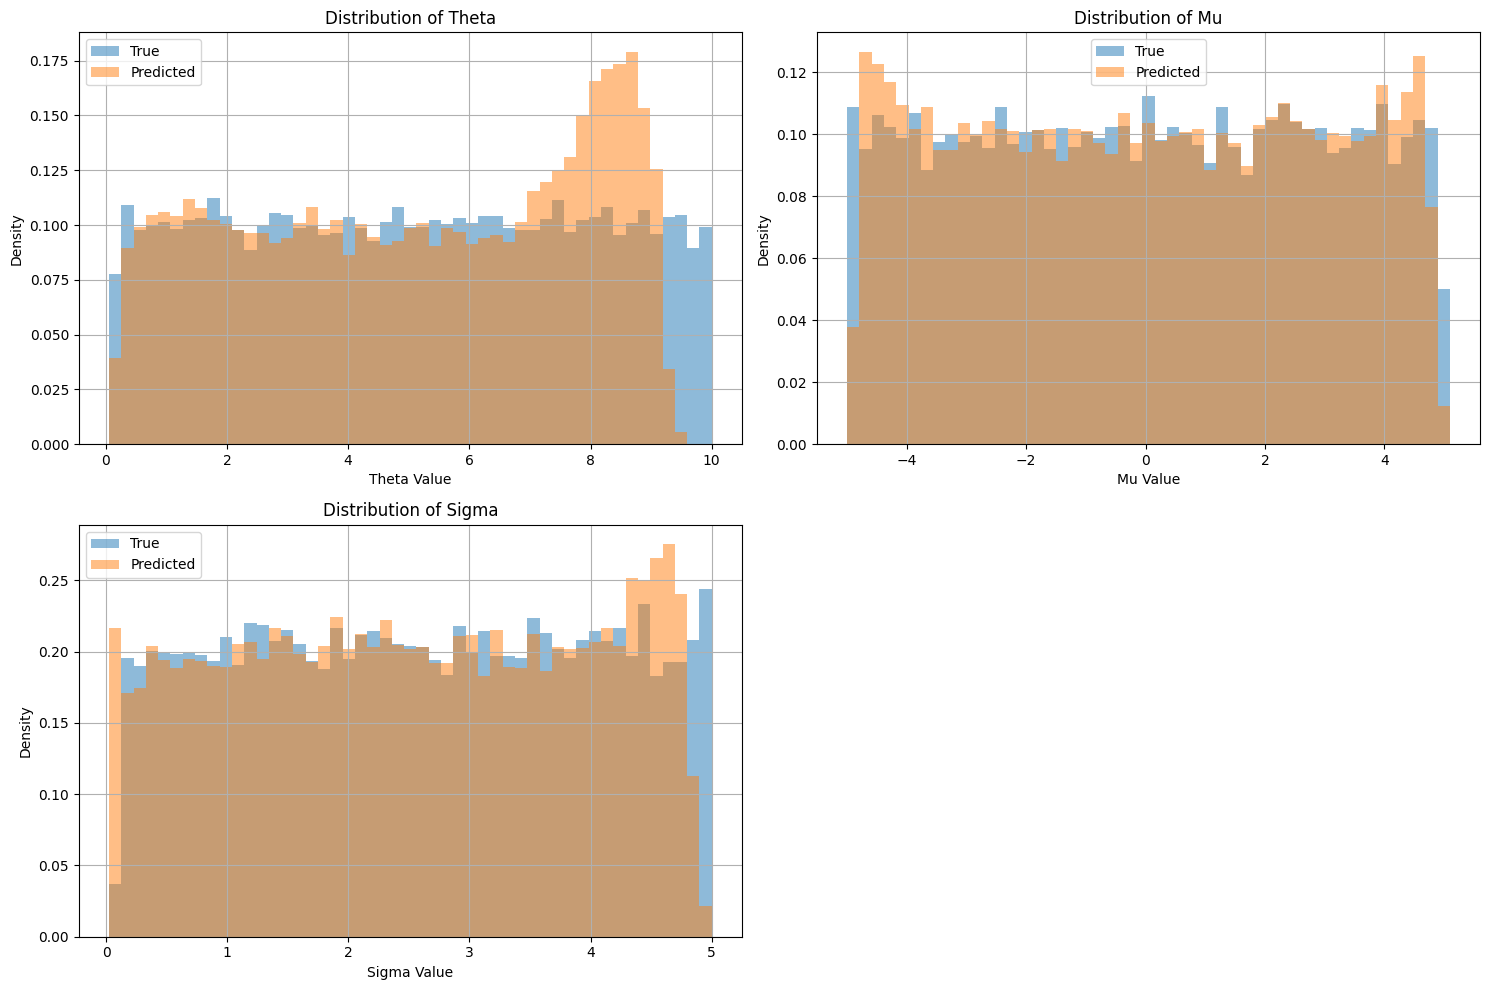

In [28]:
beautiful_print("NN", all_true, nn_preds)
beautiful_hist("NN", all_true, nn_preds)


MLE
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0438          | 2.8585          | 5.2731          | 3.0949         
Mu         | -0.0011         | 2.8917          | -0.0053         | 3.0258         
Sigma      | 2.5725          | 1.4113          | 2.6407          | 1.4514         
MSE on test using MLE: 1.00609972768531
MLE


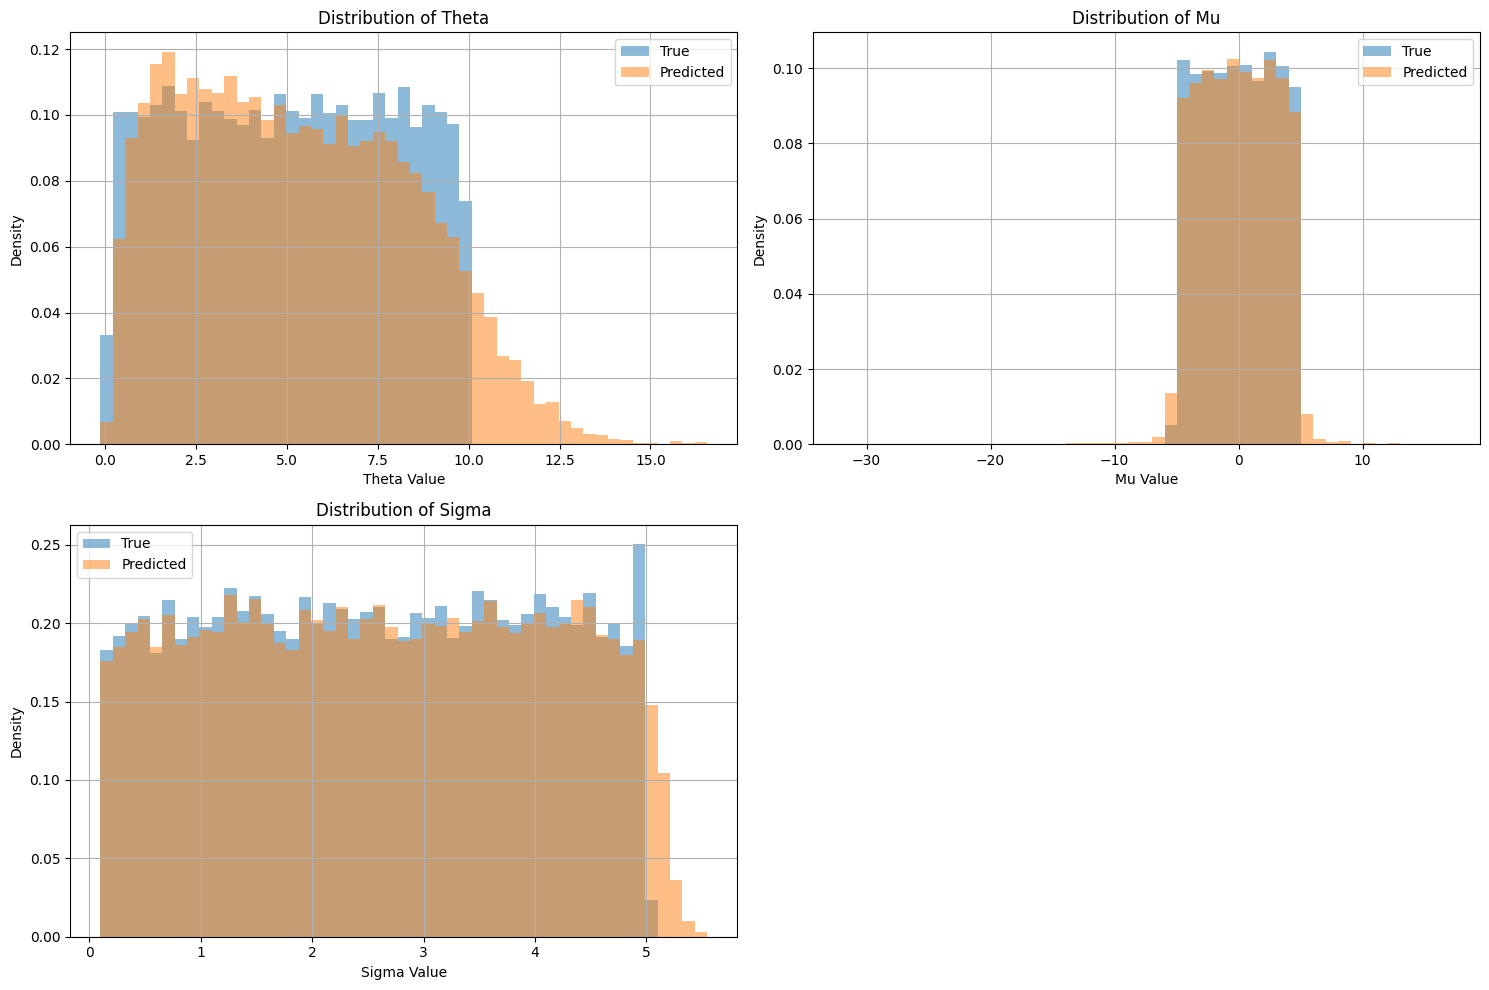

In [29]:
beautiful_print("MLE", all_true, mle_preds)
beautiful_hist("MLE", all_true, mle_preds)

MM
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0441          | 2.8583          | 5.5734          | 3.2111         
Mu         | -0.0011         | 2.8918          | -0.0019         | 2.9677         
Sigma      | 2.5725          | 1.4114          | 2.5865          | 1.4257         
MSE on test using MM: 0.7008936594031349
MM


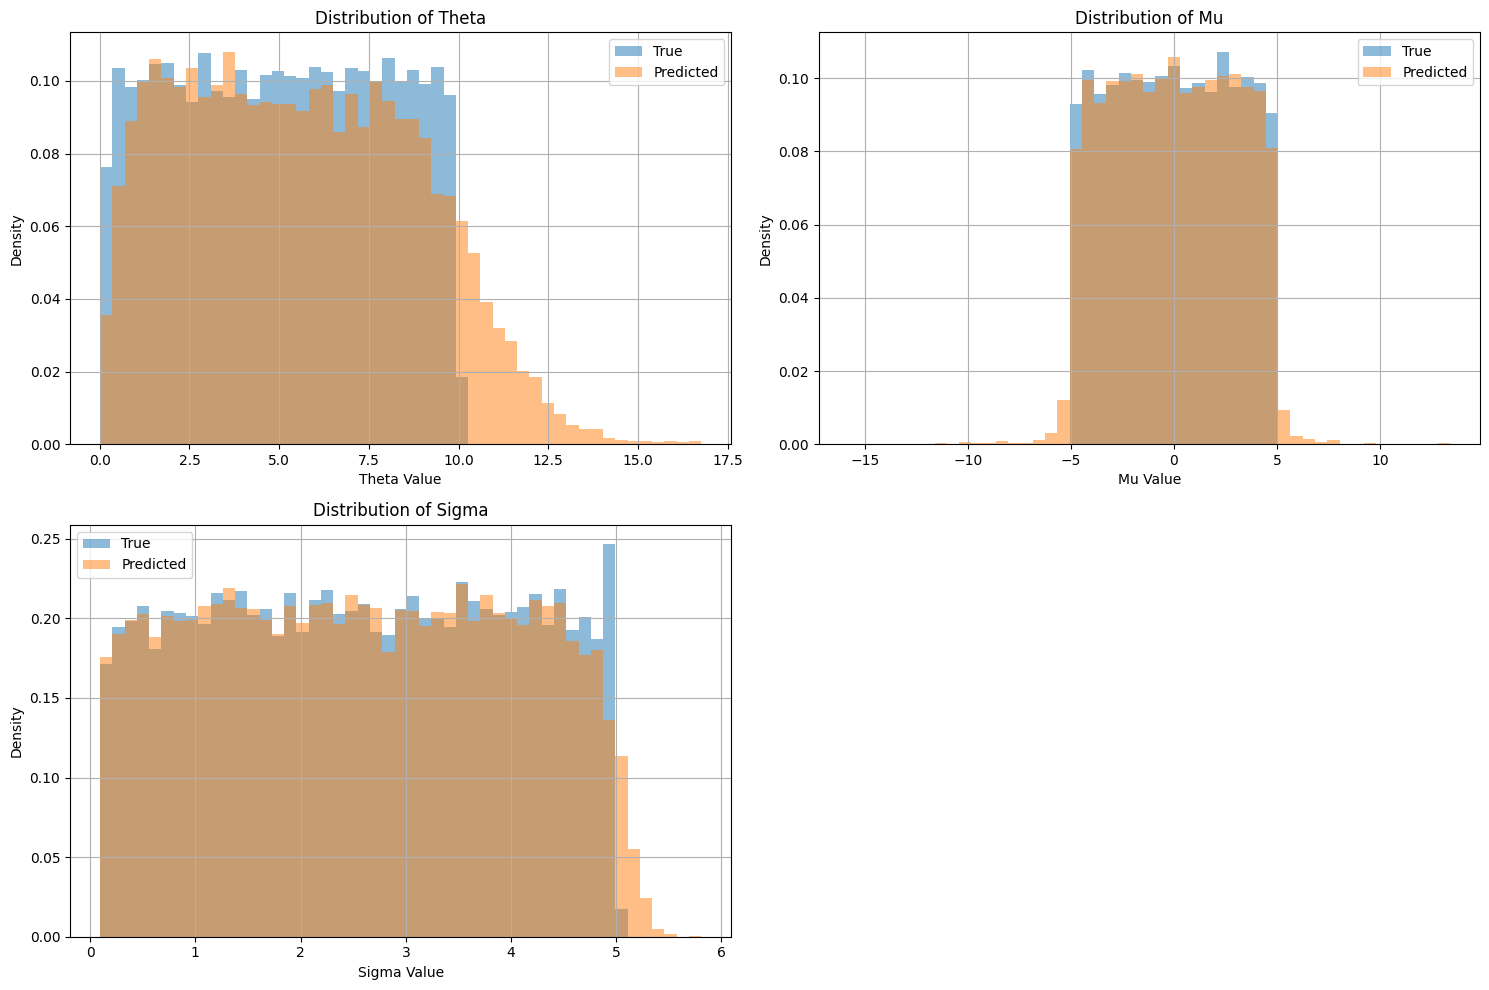

In [30]:
beautiful_print("MM", all_true[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)])
beautiful_hist("MM", all_true[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)])

In [8]:
def generate_ou_data(
                num_samples,
                traj_length,
                dt,
                theta_range,
                mu_range,
                sigma_range
                ):
    trajectories = []
    parameters = []

    for i in range(num_samples):
        theta = np.random.uniform(*theta_range)
        mu = np.random.uniform(*mu_range)
        sigma = np.random.uniform(*sigma_range)

        X = np.zeros(traj_length)
        X[0] = mu
        for t in range(1, traj_length):
            dW = np.random.normal(0, np.sqrt(dt))
            dX = theta * (mu - X[t-1]) * dt + sigma * dW
            X[t] = X[t-1] + dX
            
        trajectories.append(X)
        parameters.append([theta, mu, sigma])

    X = np.array(trajectories)[..., np.newaxis]  
    y = np.array(parameters)
    test_dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))

    return DataLoader(
            test_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=16,
            persistent_workers=16
    ), X

In [9]:
def generate_ou_trajectory(length, theta, mu, sigma, dt):
    X = np.zeros(length)
    X[0] = mu
    for t in range(1, length):
        dW = np.random.normal(0, np.sqrt(dt))
        dX = theta * (mu - X[t-1]) * dt + sigma * dW
        X[t] = X[t-1] + dX
    return X

100%|██████████| 100/100 [58:54<00:00, 35.35s/it]


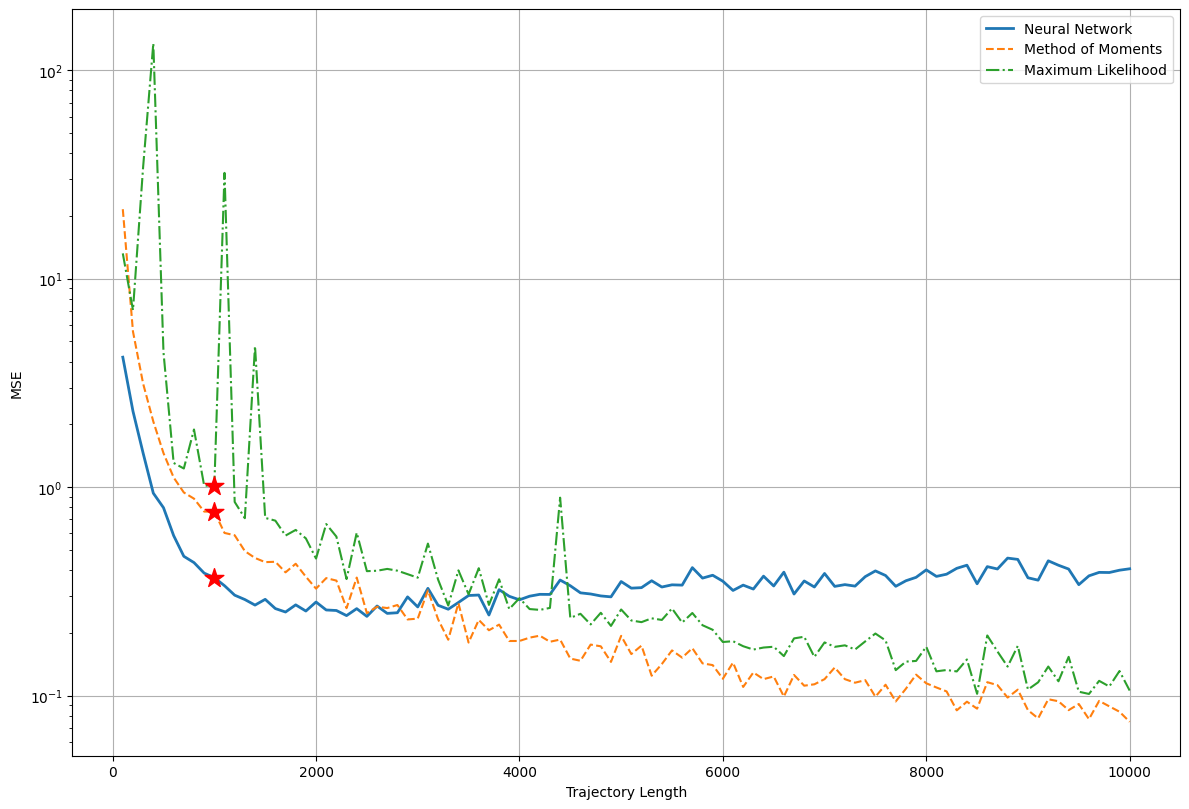

In [35]:
def calculate_mse(model, length_range):
    mse_results = {'NN': [], 'MM': [], 'MLE': []}
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()  
    
    for length in tqdm(length_range):
        test_loader, X = generate_ou_data(
            num_samples=1000,
            traj_length=length,
            dt=0.01,
            theta_range=(0.1, 10.0),
            mu_range=(-5, 5),
            sigma_range=(0.1, 5.0),
        )

        nn_preds = []
        all_true = []

        with torch.no_grad():
            for batch in test_loader:
                x, y = batch
                x = x.to(device)
                preds = model(x)

                nn_preds.append(preds.cpu().numpy())
                all_true.append(y.numpy())

        nn_preds = np.concatenate(nn_preds)
        all_true = np.concatenate(all_true)

        math_X_test = X[:,:,0]
        mle_preds = [] 
        mm_preds = []

        for i in range(math_X_test.shape[0]):
            mle_preds.append(list(estimate_params_MLE(X=math_X_test[i], dt=0.01)))
            mm_preds.append(list(estimate_params_MM(X=math_X_test[i], dt=0.01)))
        mle_preds = np.array(mle_preds)
        mm_preds = np.array(mm_preds)
        mask = np.isnan(mm_preds) # возникает 1 нан при подсчёте оценок по методу моментов
        
        mse_results['MLE'].append(mean_squared_error(mle_preds, all_true))
        mse_results['MM'].append(mean_squared_error(mm_preds[~np.any(mask, axis=1)], all_true[~np.any(mask, axis=1)]))
        mse_results['NN'].append(mean_squared_error(nn_preds, all_true))
    return mse_results
        
        
        
lengths = np.arange(100, 10001, 100)
mse_results = calculate_mse(best_model, lengths)


plt.figure(figsize=(12, 8))

# Neural Network
plt.plot(lengths, mse_results['NN'],
         label='Neural Network', linewidth=2)

# Method of Moments
plt.plot(lengths, mse_results['MM'],
         '--', label='Method of Moments')

# Maximum Likelihood
plt.plot(lengths, mse_results['MLE'],
         '-.', label='Maximum Likelihood')

idx = np.where(lengths == 1000)[0][0]
plt.scatter(lengths[idx], mse_results['NN'][idx],
            c='red', marker='*', s=200, zorder=10)
plt.scatter(lengths[idx], mse_results['MM'][idx],
            c='red', marker='*', s=200, zorder=10)
plt.scatter(lengths[idx], mse_results['MLE'][idx],
            c='red', marker='*', s=200, zorder=10)

plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.xlabel('Trajectory Length')
plt.show()

In [71]:
def plot_increment_histograms(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    
    lengths = [100, 1000, 2000, 5000, 10000]
    methods = ['True', 'NN', 'MLE', 'MM']
    colors = ['blue', 'green', 'red', 'orange']
    
    for length in tqdm(lengths):
        fig, axs = plt.subplots(1, 4, figsize=(24, 8))  
        
        # Генерируем оригинальную траекторию
        true_theta = 2.5
        true_mu = -3
        true_sigma = 1
        
        # Генерируем истинную траекторию
        X_true = generate_ou_trajectory(
            length=length, 
            theta=true_theta,
            mu=true_mu,
            sigma=true_sigma,
            dt=0.01
        )
        true_diffs = np.diff(X_true)
        
        # Получаем оценки параметров
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_true).unsqueeze(0).unsqueeze(-1).to(device)
            nn_pred = model(X_tensor).cpu().numpy()[0]
        mle_pred = estimate_params_MLE(X_true, dt=0.01)
        mm_pred = estimate_params_MM(X_true, dt=0.01)


        # Генерируем траектории из оценок
        generated = {
            'True': (true_theta, true_mu, true_sigma),
            'NN': nn_pred,
            'MLE': mle_pred,
            'MM': mm_pred
        }
        
        # Рисуем гистограммы для каждого метода
        for col, method in enumerate(methods):
            ax = axs[col]  # Получаем текущий подграфик
            theta, mu, sigma = generated[method]
                
            # Генерируем траекторию с оцененными параметрами
            X_gen = generate_ou_trajectory(
                length=length,
                theta=theta,
                mu=mu,
                sigma=sigma,
                dt=0.01
            )
            gen_diffs = np.diff(X_gen)
            
            # Рисуем гистограммы
            bins = np.linspace(-5*true_sigma, 5*true_sigma, 50)
            ax.hist(true_diffs, bins=bins, alpha=0.5, 
                    color='blue', density=True, label='True')
            ax.hist(gen_diffs, bins=bins, alpha=0.5, 
                    color=colors[col], density=True, label='Generated')
            
            ax.set_title(f'Length {length} - {method}\n'
                        f'True: θ={true_theta:.2f}, μ={true_mu:.2f}, σ={true_sigma:.2f}\n'
                        f'Est: θ={theta:.2f}, μ={mu:.2f}, σ={sigma:.2f}')
            ax.set_xlabel('Increment Value')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

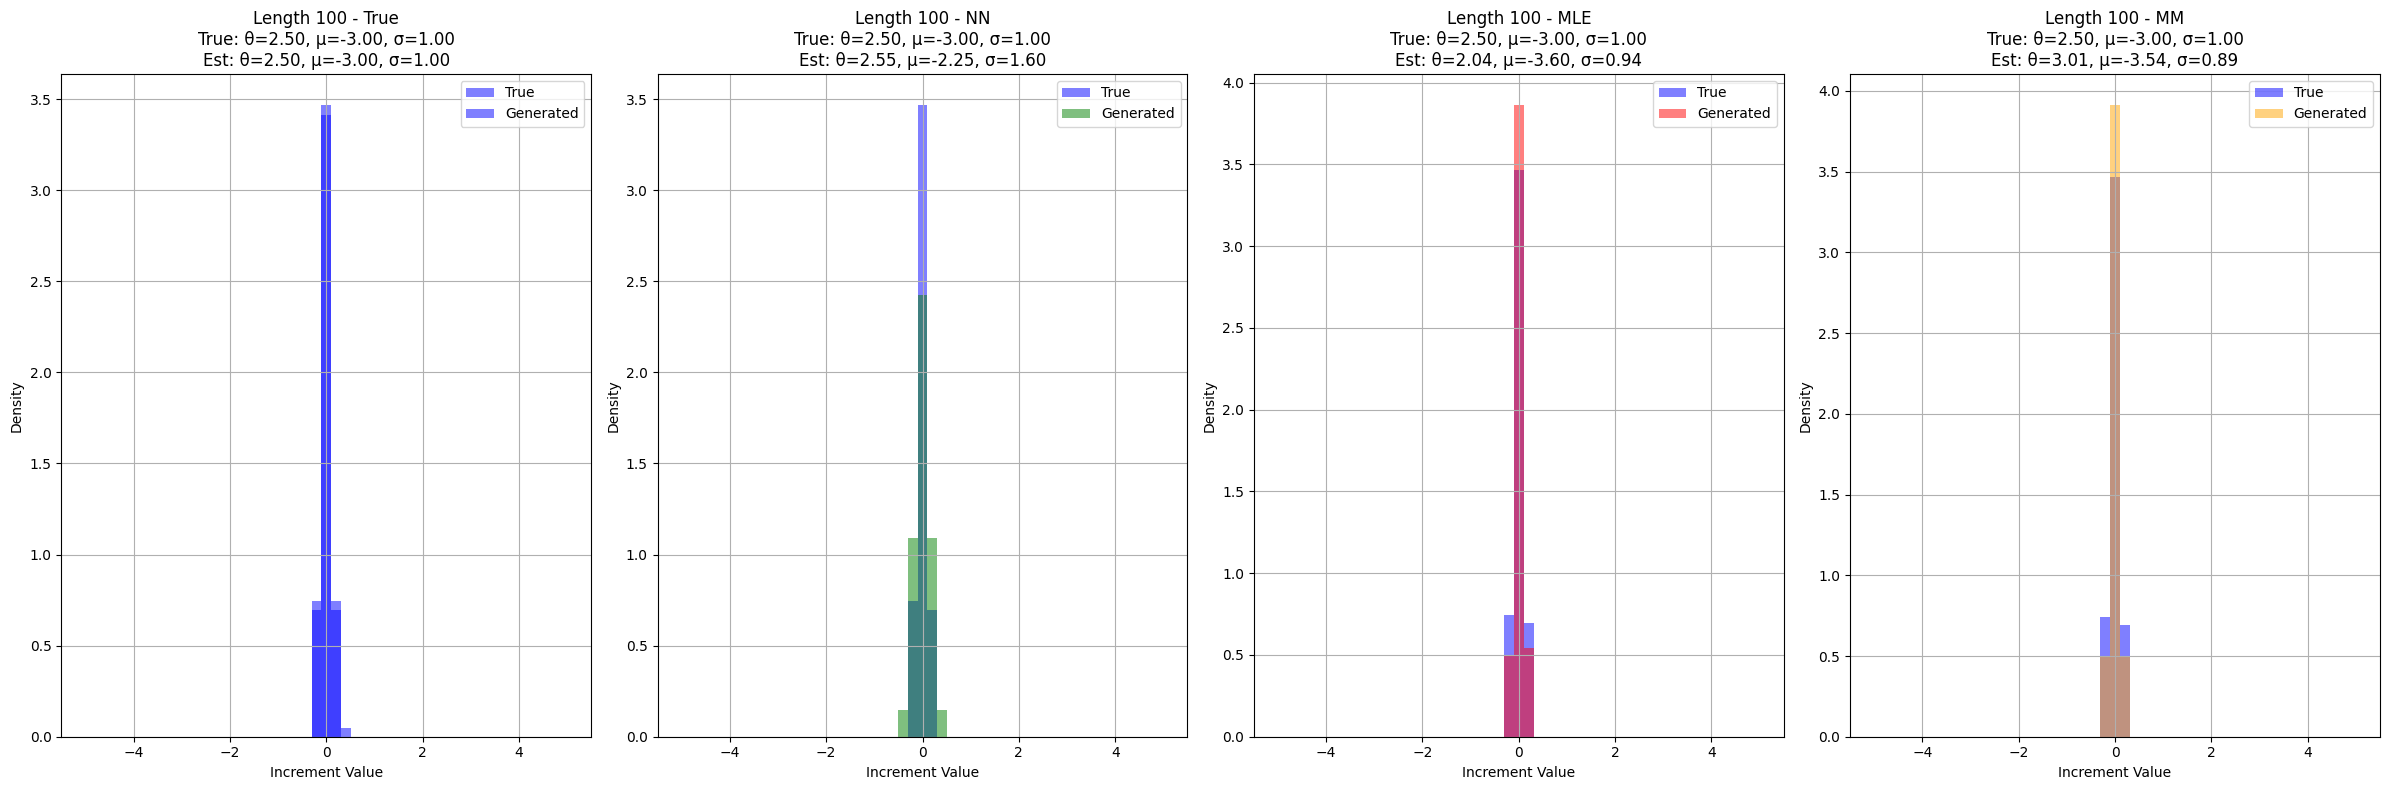

 20%|██        | 1/5 [00:01<00:05,  1.33s/it]

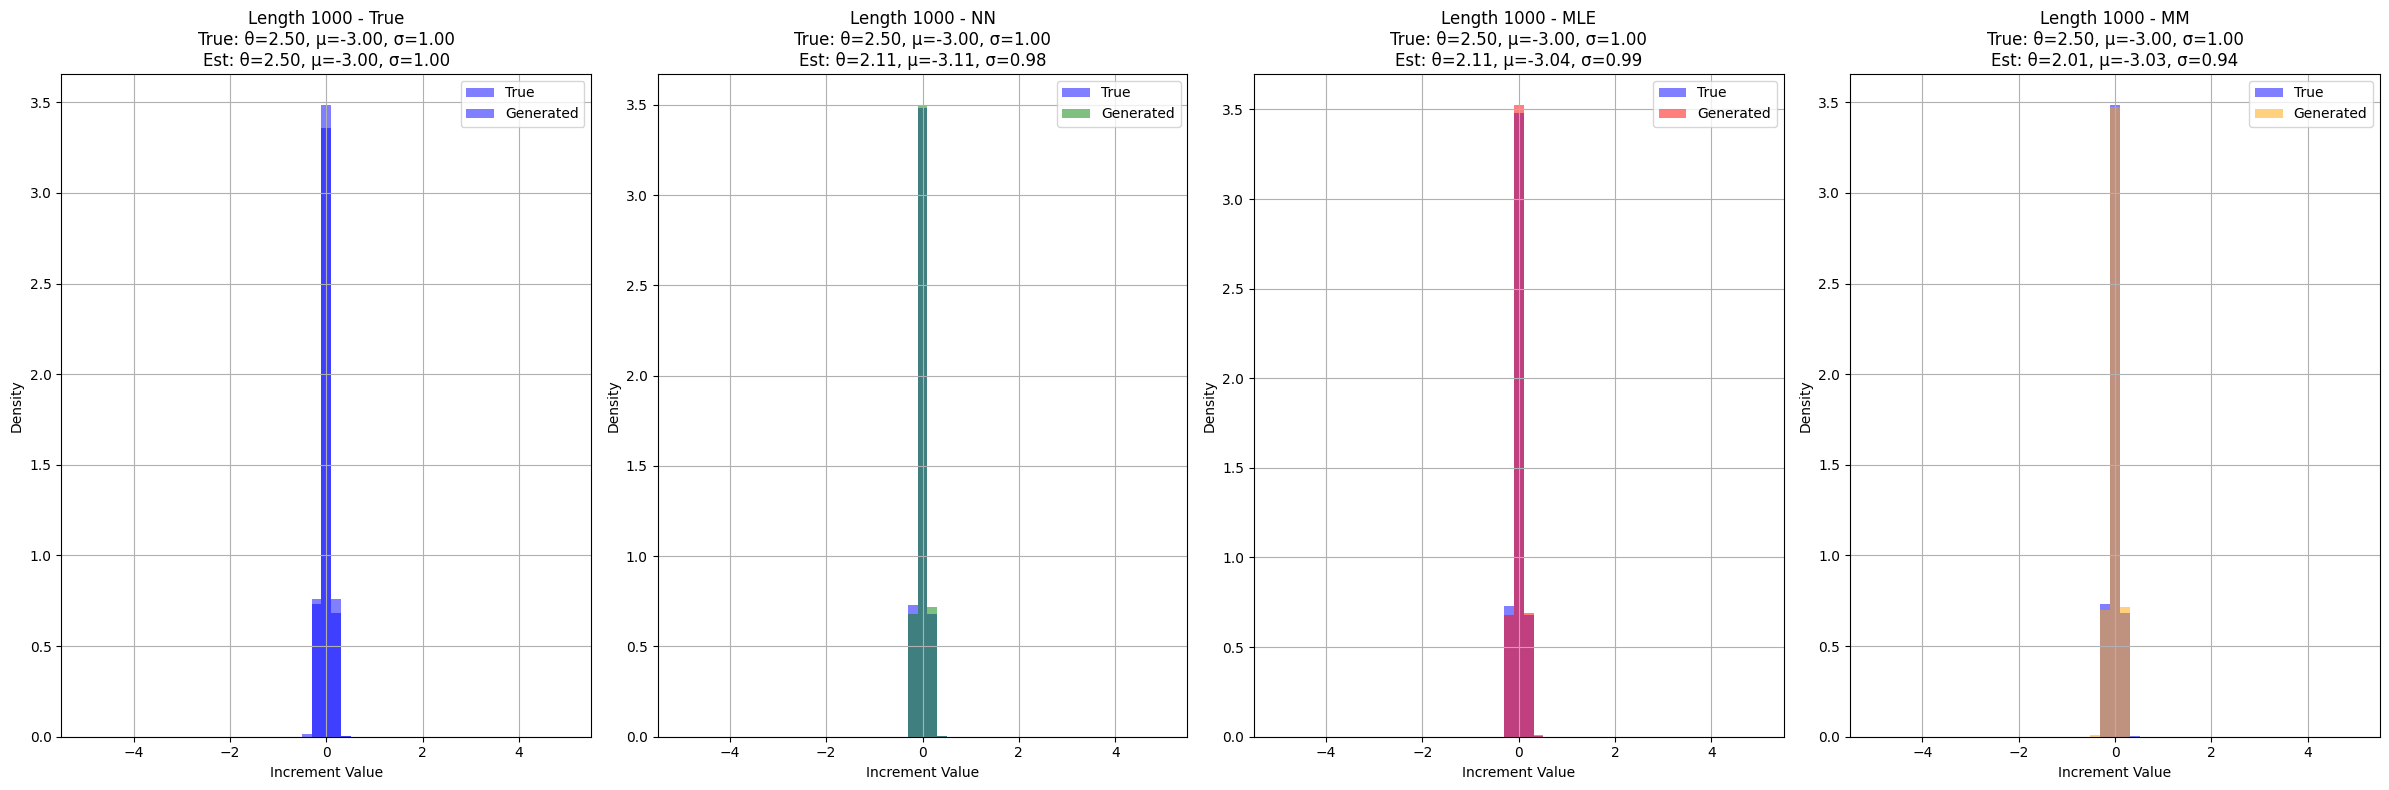

 40%|████      | 2/5 [00:03<00:04,  1.56s/it]

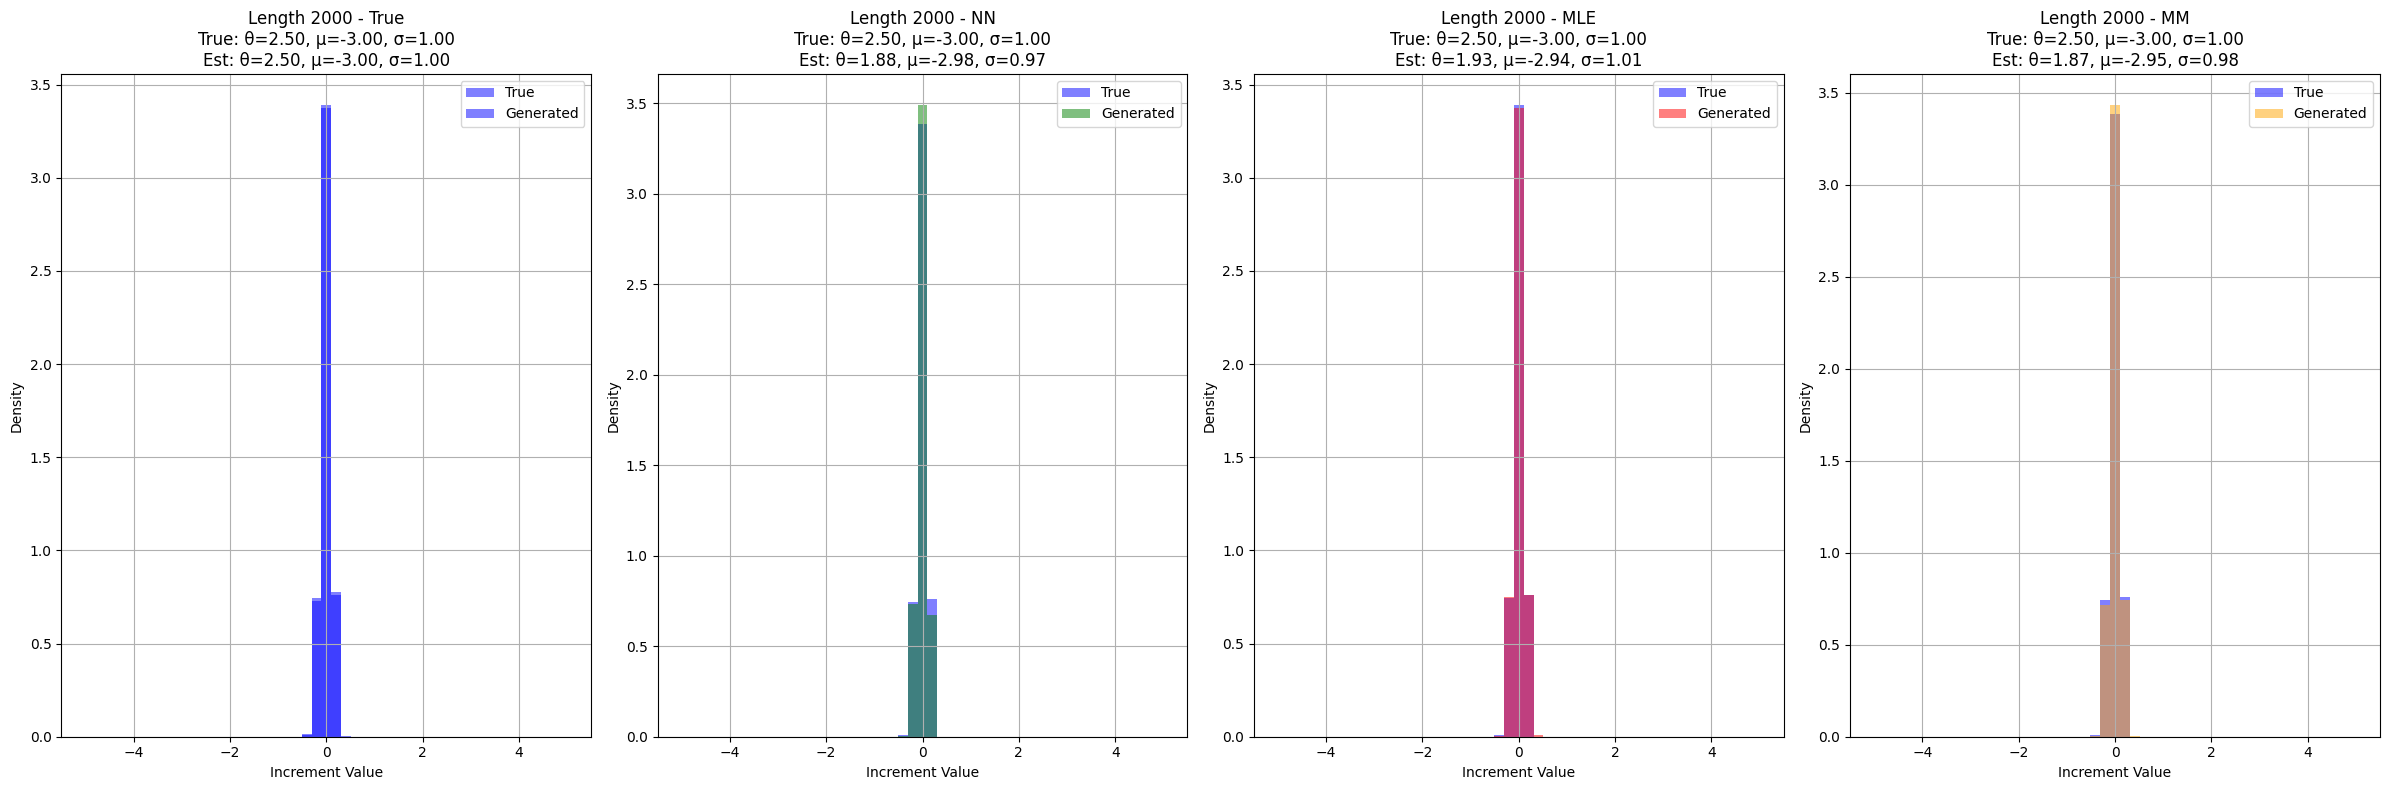

 60%|██████    | 3/5 [00:04<00:03,  1.60s/it]

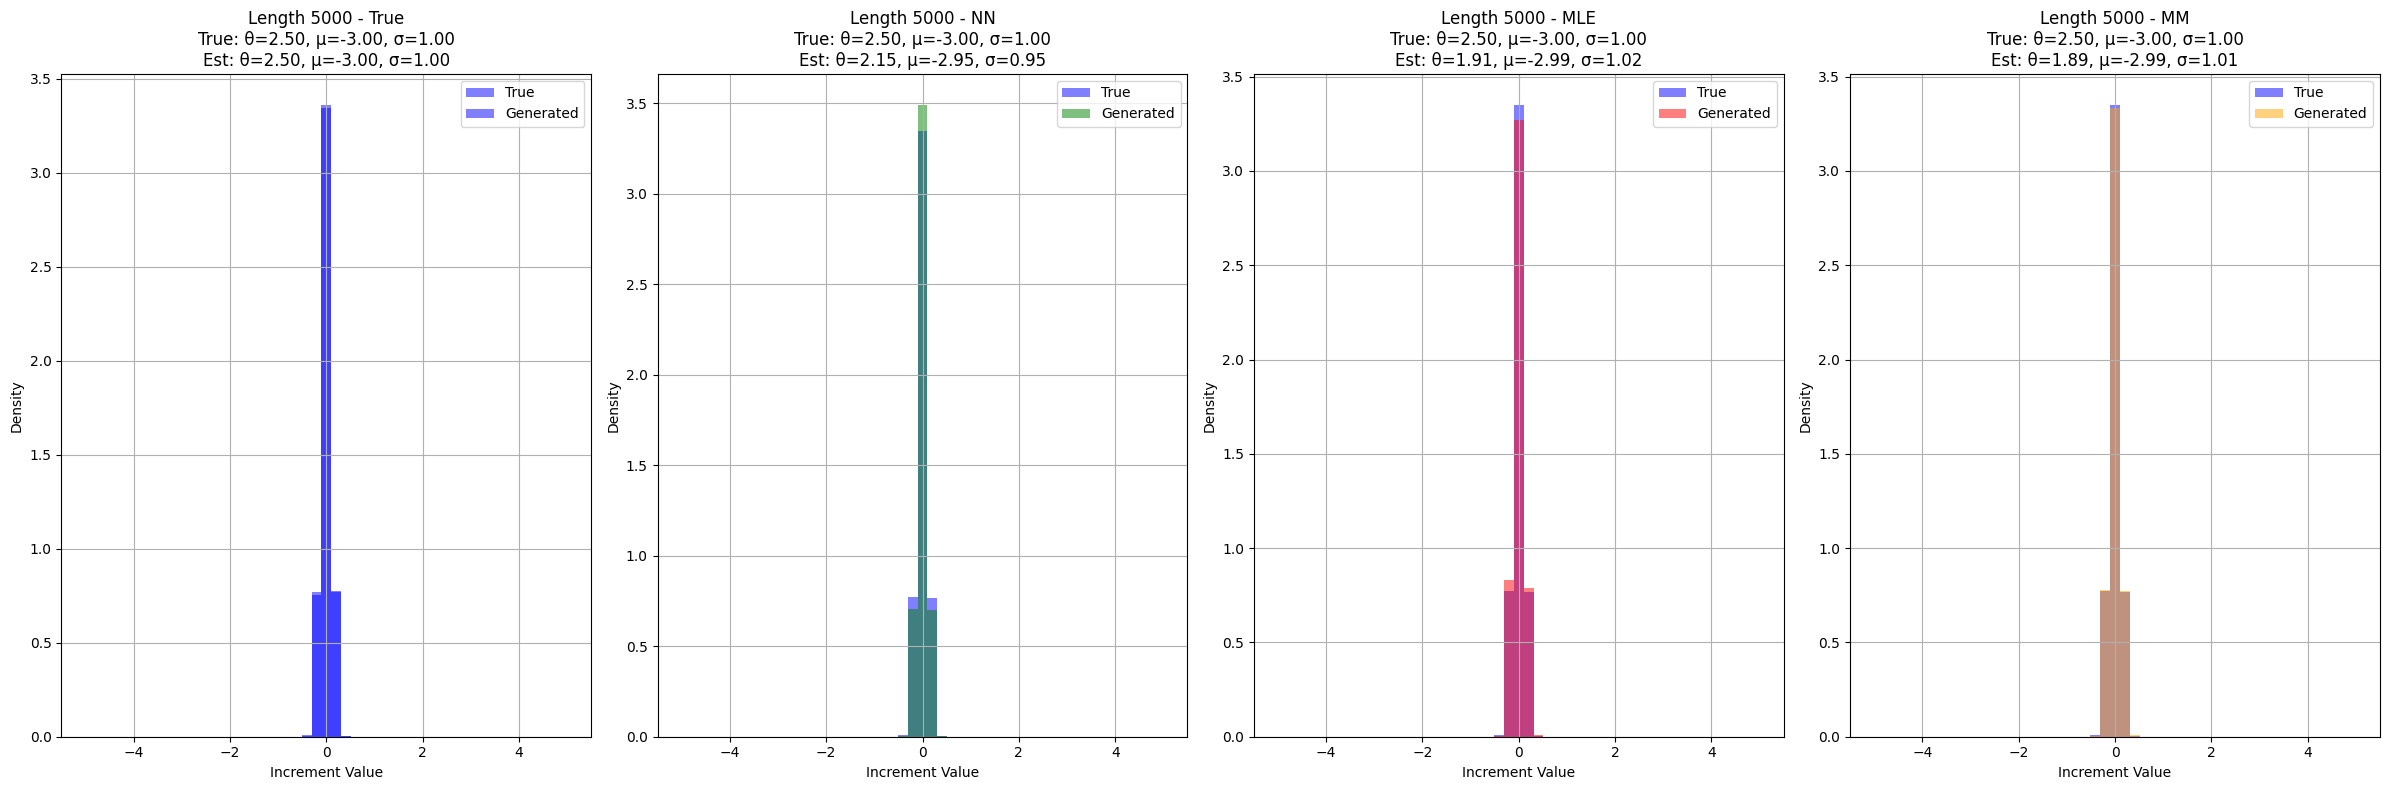

 80%|████████  | 4/5 [00:06<00:01,  1.86s/it]

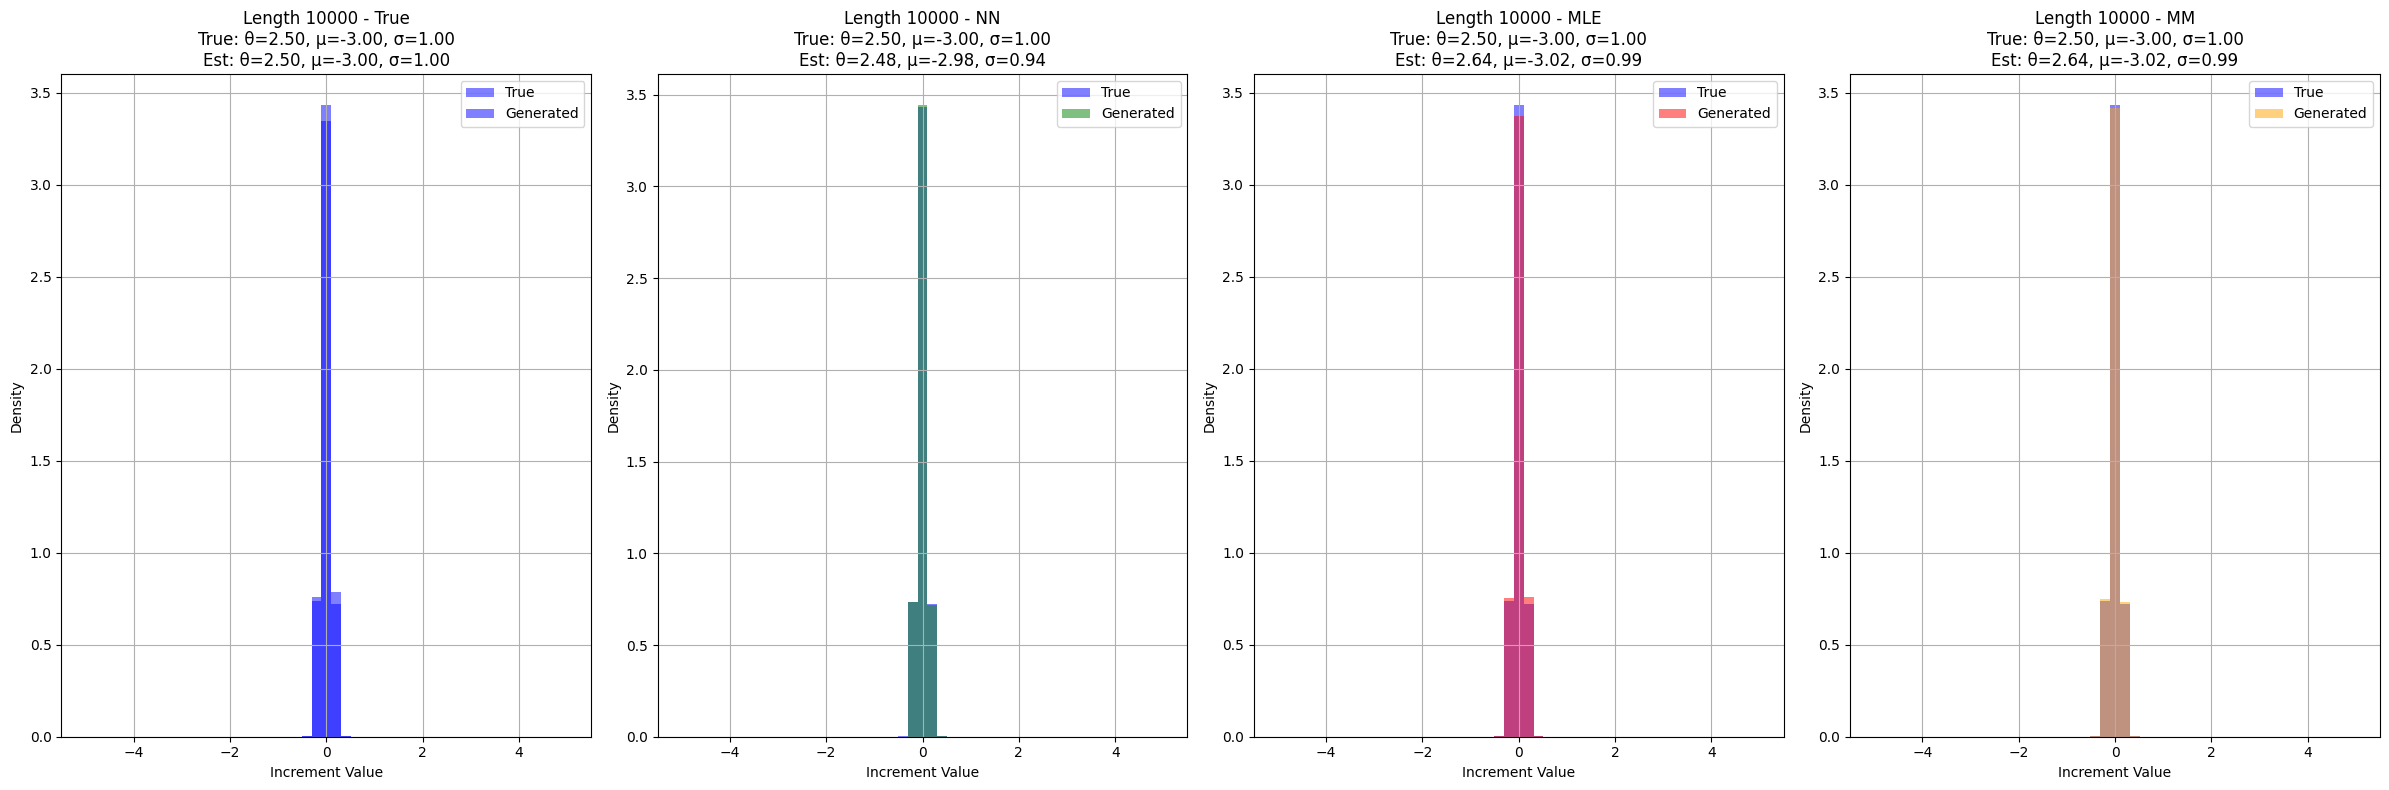

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


In [72]:
plot_increment_histograms(best_model)

In [103]:
mm_preds = []
mle_preds = []
nn_preds = []
real_pred = [2.5, -3, 1]
real_preds = []

for i in range(100):
    X_true = generate_ou_trajectory(
                length=100, 
                theta=2.5,
                mu=-3,
                sigma=1,
                dt=0.01
            )

    mle_pred = estimate_params_MLE(X_true, dt=0.01)
    mm_pred = estimate_params_MM(X_true, dt=0.01)
    mle_preds.append(mle_pred)
    mm_preds.append(mm_pred)
    real_preds.append(real_pred)
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_true).unsqueeze(0).unsqueeze(-1).to(device)
        nn_pred = model(X_tensor).cpu().numpy()[0]
        nn_preds.append(nn_pred)
        

mm_preds = np.array(mm_preds)
mle_preds = np.array(mle_preds)
nn_preds = np.array(nn_preds)
real_preds = np.array(real_preds)
mask = np.isnan(mm_preds)

mean_squared_error(real_preds[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)]), mean_squared_error(real_preds, mle_preds), mean_squared_error(real_preds, nn_preds)

(21.473989283713593, 0.5933331275645932, 5.325475554433868)

In [106]:
mm_preds = []
mle_preds = []
nn_preds = []
real_pred = [2.5, -3, 1]
real_preds = []

for i in range(1000):
    X_true = generate_ou_trajectory(
                length=100, 
                theta=2.5,
                mu=-3,
                sigma=1,
                dt=0.01
            )

    mle_pred = estimate_params_MLE(X_true, dt=0.01)
    mm_pred = estimate_params_MM(X_true, dt=0.01)
    mle_preds.append(mle_pred)
    mm_preds.append(mm_pred)
    real_preds.append(real_pred)
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_true).unsqueeze(0).unsqueeze(-1).to(device)
        nn_pred = model(X_tensor).cpu().numpy()[0]
        nn_preds.append(nn_pred)
        

mm_preds = np.array(mm_preds)
mle_preds = np.array(mle_preds)
nn_preds = np.array(nn_preds)
real_preds = np.array(real_preds)
mask = np.isnan(mm_preds)

mean_squared_error(real_preds[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)]), mean_squared_error(real_preds, mle_preds), mean_squared_error(real_preds, nn_preds)

(17.49923871194888, 19.7887454380951, 4.8974037764381855)

In [10]:
def plot_parameter_histograms(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    
    lengths = [100, 1000, 10000]
    methods = ['True', 'NN', 'MLE', 'MM']
    params = ['theta', 'mu', 'sigma']
    true_params = [2.5, -3, 1]
    colors = ['blue', 'green', 'red', 'orange']
    
    for length in tqdm(lengths):
        mm_preds = []
        mle_preds = []
        nn_preds = []
        real_preds = []
        
        for i in range(10000):
            if i % 1000 == 0:
                print(f"Generate {i}/10000 trajectories")
            X_true = generate_ou_trajectory(
                length=length, 
                theta=true_params[0],
                mu=true_params[1],
                sigma=true_params[2],
                dt=0.01
            )
            
            real_preds.append(true_params)
        
            mle_pred = estimate_params_MLE(X_true, dt=0.01)
            mle_preds.append(mle_pred)
            
            mm_pred = estimate_params_MM(X_true, dt=0.01)
            mm_preds.append(mm_pred)
            
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X_true).unsqueeze(0).unsqueeze(-1).to(device)
                nn_pred = model(X_tensor).cpu().numpy()[0]
                nn_preds.append(nn_pred)
        
        real_preds = np.array(real_preds)
        nn_preds = np.array(nn_preds)
        mle_preds = np.array(mle_preds)
        mm_preds = np.array(mm_preds)
        
        for param_idx, param_name in enumerate(params):
            plt.figure(figsize=(12, 8))
            
            data = {
                'True': real_preds[:, param_idx],
                'NN': nn_preds[:, param_idx],
                'MLE': mle_preds[:, param_idx],
                'MM': mm_preds[:, param_idx]
            }
            
            for method_idx, (method, values) in enumerate(data.items()):
                plt.subplot(2, 2, method_idx+1)
                
                clean_values = values[~np.isnan(values)]
                if len(clean_values) == 0:
                    plt.text(0.5, 0.5, 'No valid estimates', 
                            ha='center', va='center')
                    continue
                
                plt.hist(clean_values, bins=30, alpha=0.7, 
                        color=colors[method_idx], density=True)
                
                plt.axvline(true_params[param_idx], color='black', 
                           linestyle='dashed', linewidth=2)
                
                plt.title(f'{method} - {param_name}')
                plt.xlabel('Parameter Value')
                plt.ylabel('Density')
                plt.grid(True)
            
            plt.suptitle(f'Parameter: {param_name}, Length: {length}\n'
                        f'True Values: θ={true_params[0]}, μ={true_params[1]}, σ={true_params[2]}',
                        y=1.02)
            plt.tight_layout()
            plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

Generate 0/10000 trajectories
Generate 1000/10000 trajectories
Generate 2000/10000 trajectories
Generate 3000/10000 trajectories
Generate 4000/10000 trajectories
Generate 5000/10000 trajectories
Generate 6000/10000 trajectories
Generate 7000/10000 trajectories
Generate 8000/10000 trajectories
Generate 9000/10000 trajectories


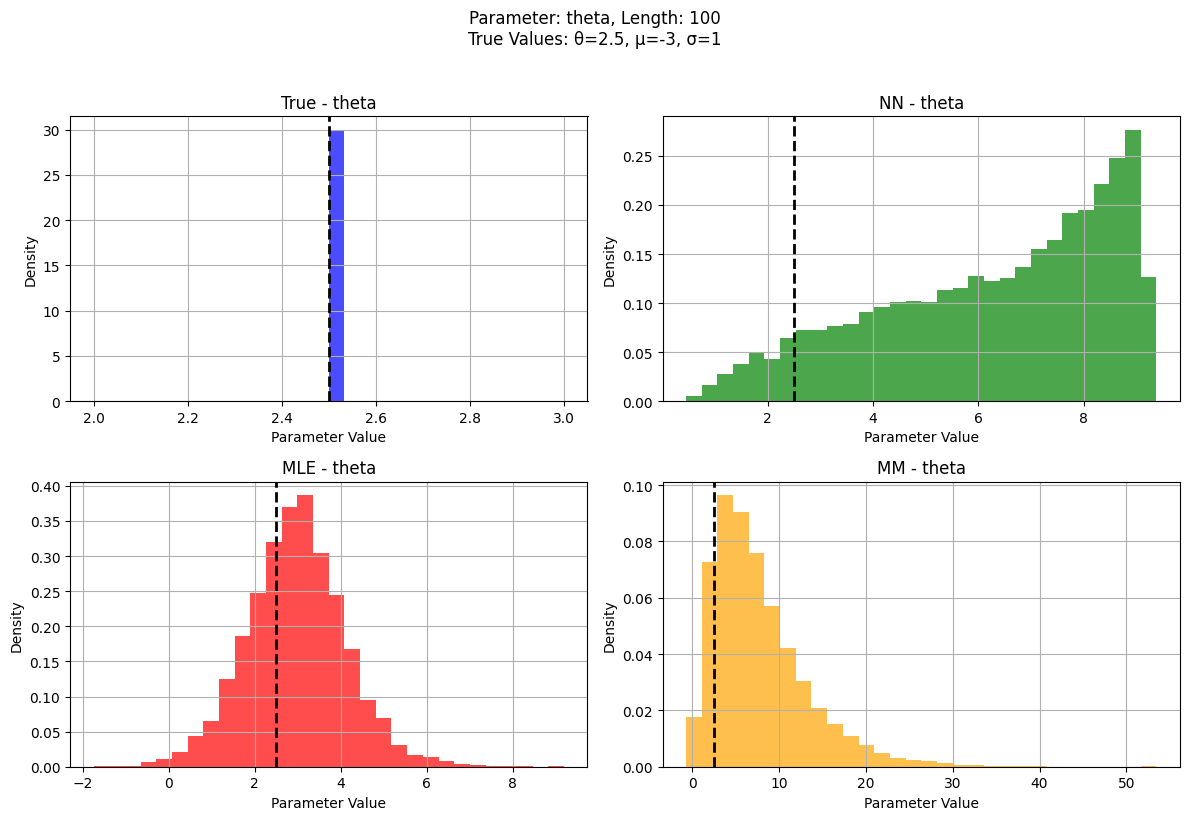

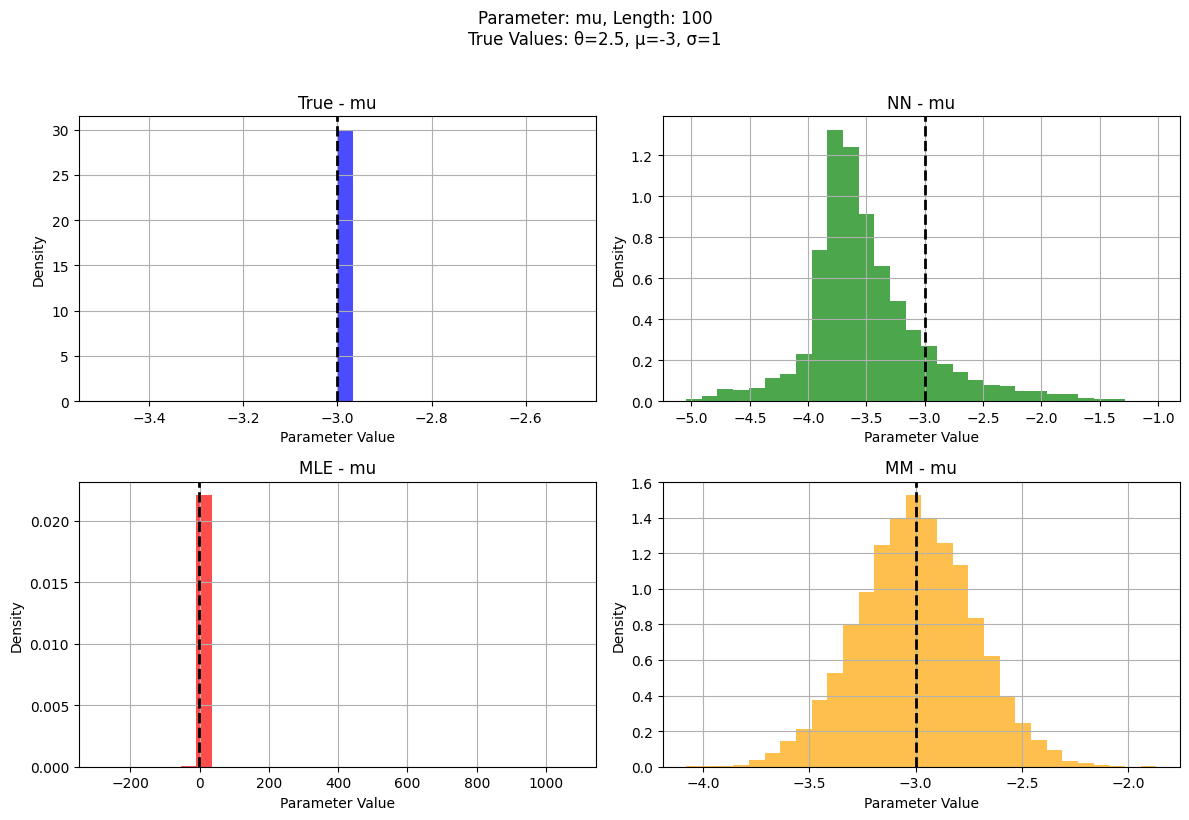

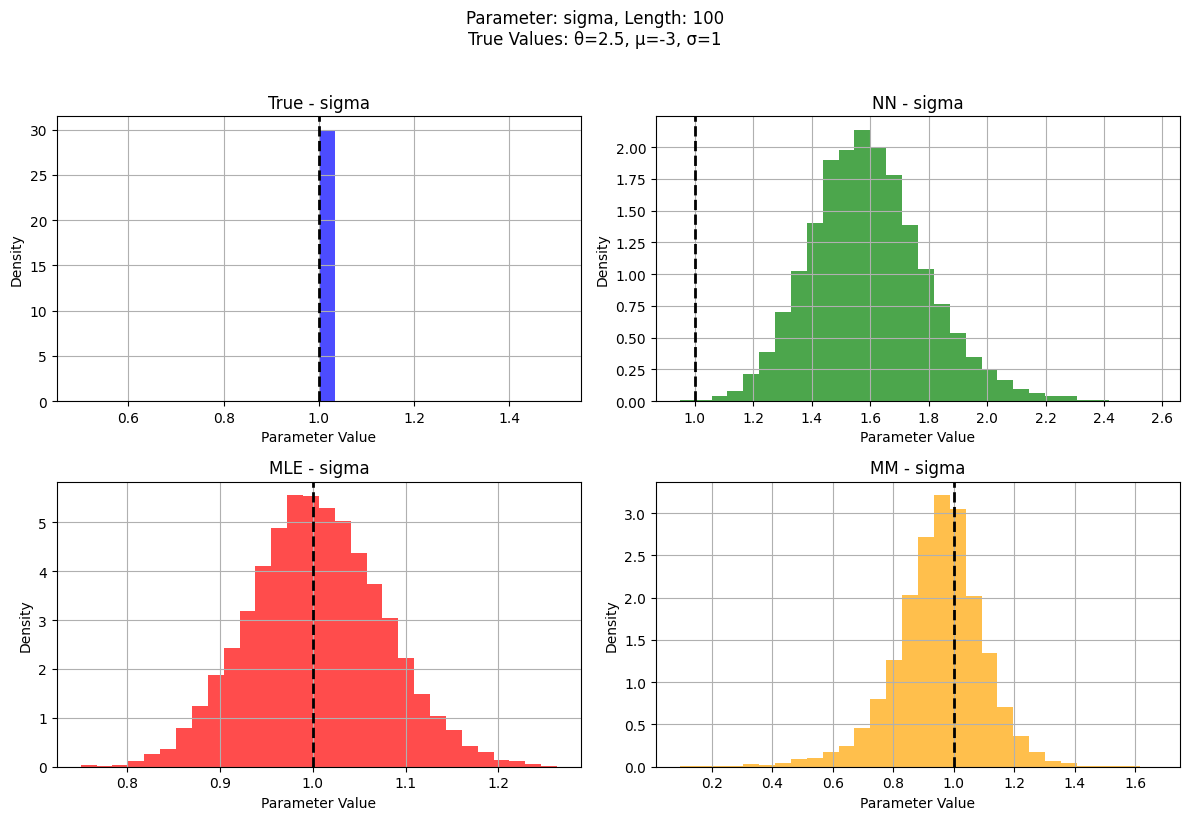

 33%|███▎      | 1/3 [02:16<04:33, 136.96s/it]

Generate 0/10000 trajectories
Generate 1000/10000 trajectories
Generate 2000/10000 trajectories
Generate 3000/10000 trajectories
Generate 4000/10000 trajectories
Generate 5000/10000 trajectories
Generate 6000/10000 trajectories
Generate 7000/10000 trajectories
Generate 8000/10000 trajectories
Generate 9000/10000 trajectories


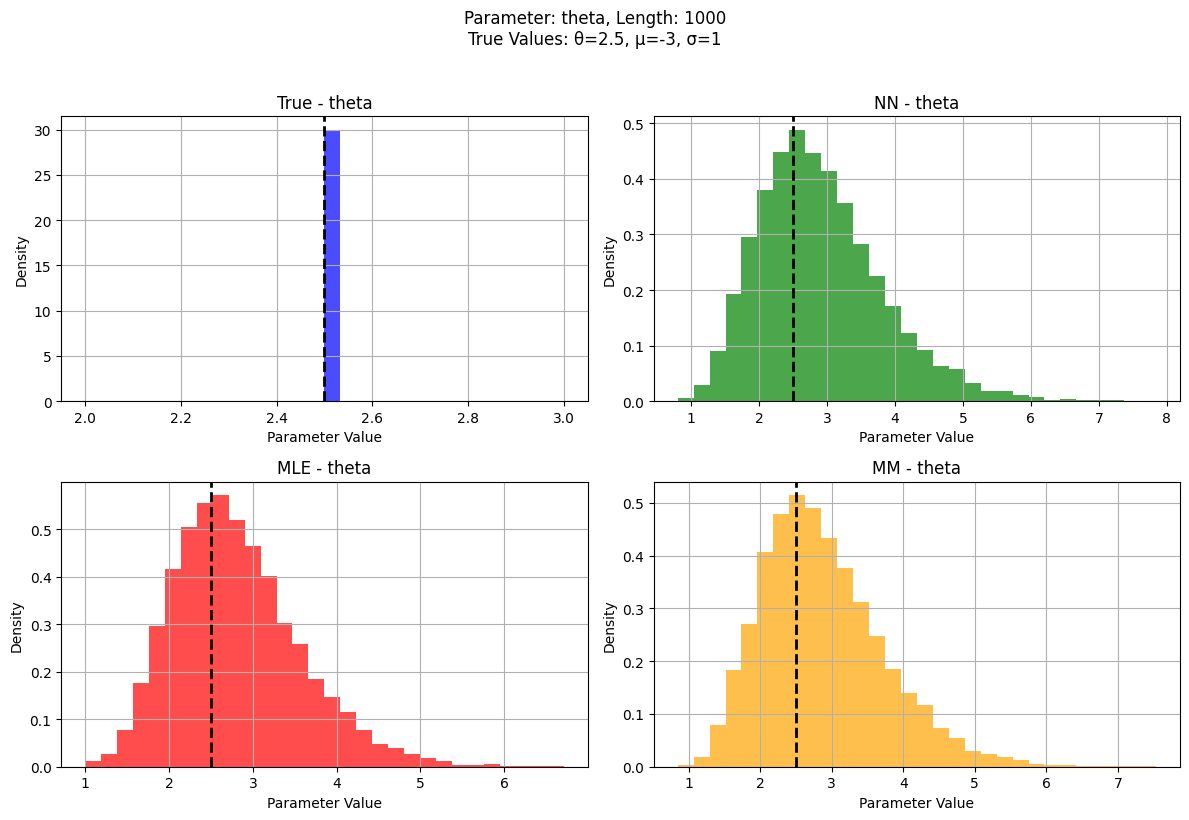

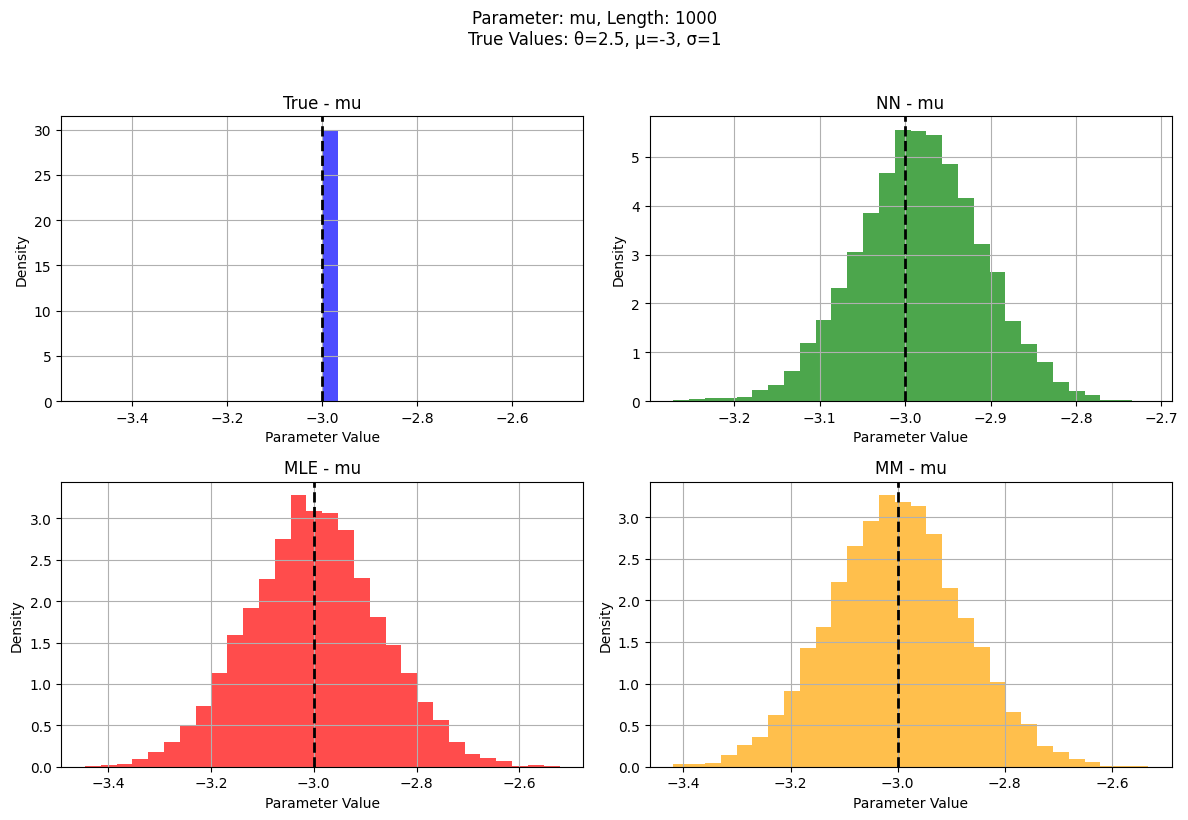

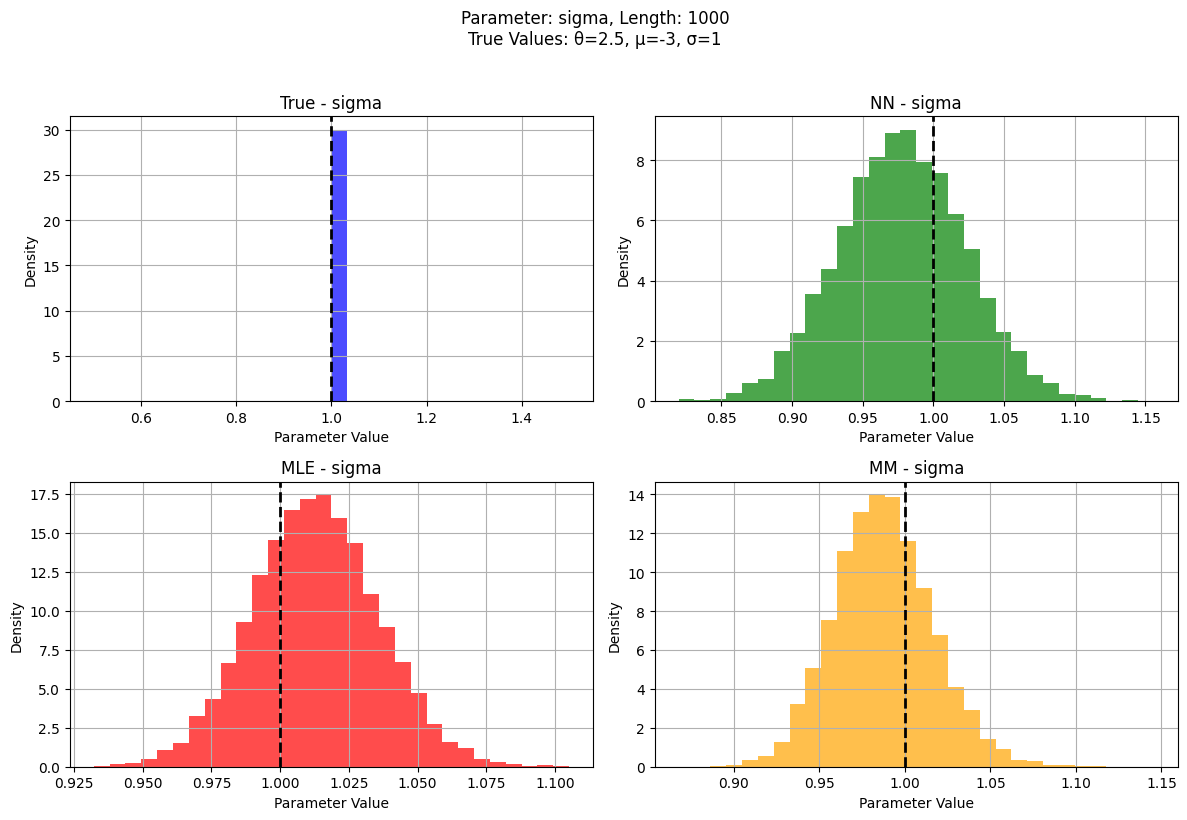

 67%|██████▋   | 2/3 [25:00<14:18, 858.24s/it]

Generate 0/10000 trajectories
Generate 1000/10000 trajectories
Generate 2000/10000 trajectories
Generate 3000/10000 trajectories
Generate 4000/10000 trajectories
Generate 5000/10000 trajectories
Generate 6000/10000 trajectories
Generate 7000/10000 trajectories
Generate 8000/10000 trajectories
Generate 9000/10000 trajectories


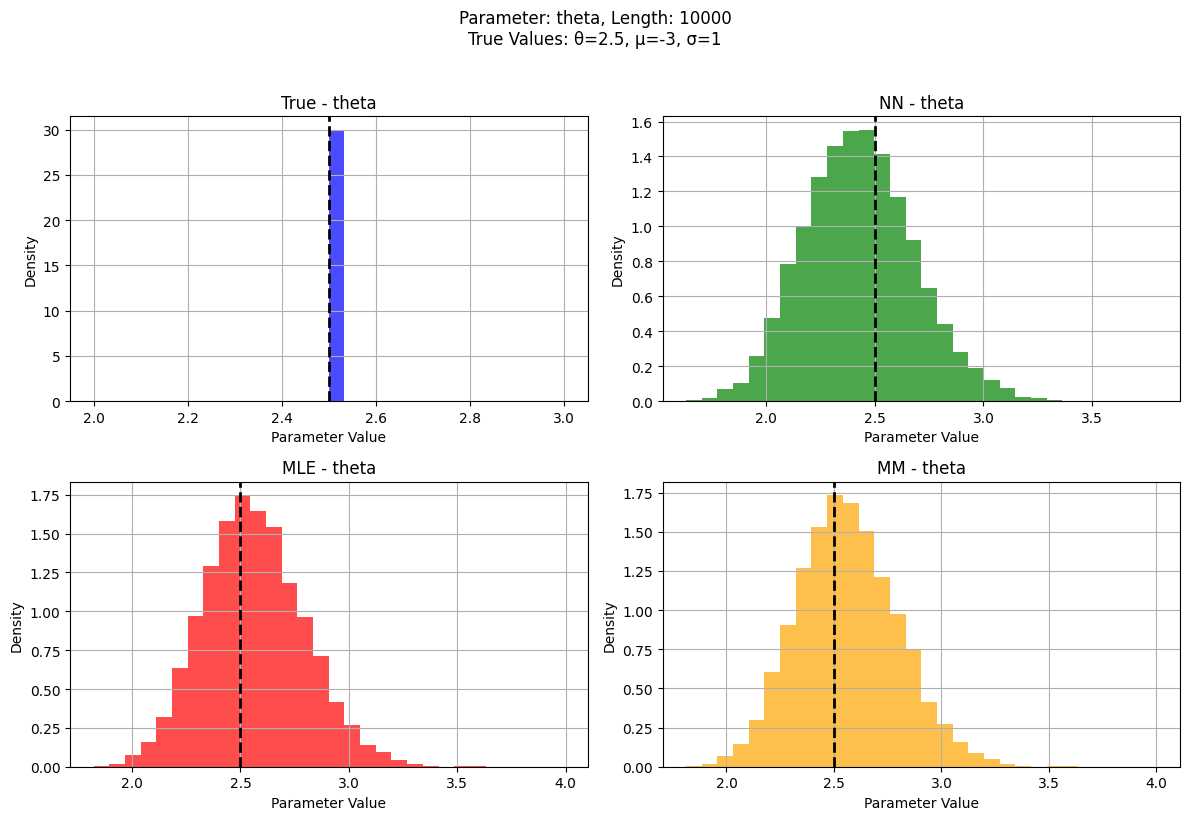

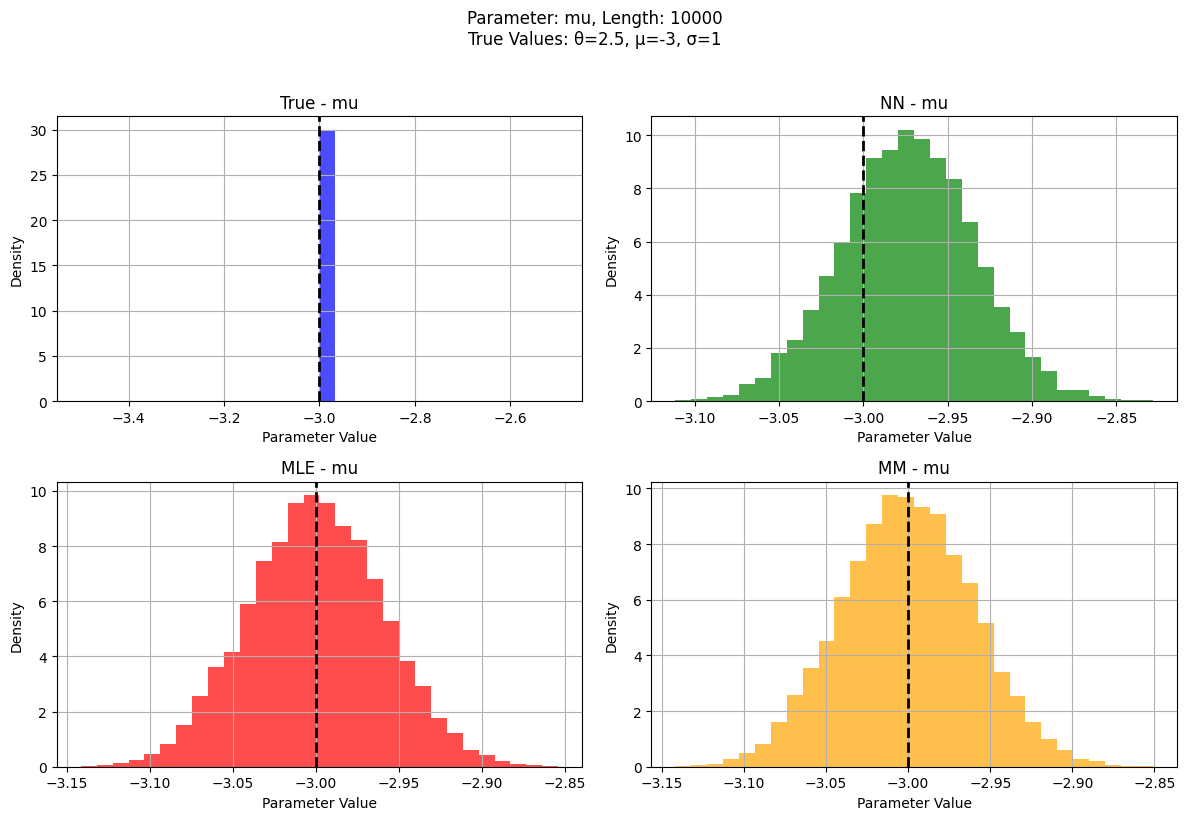

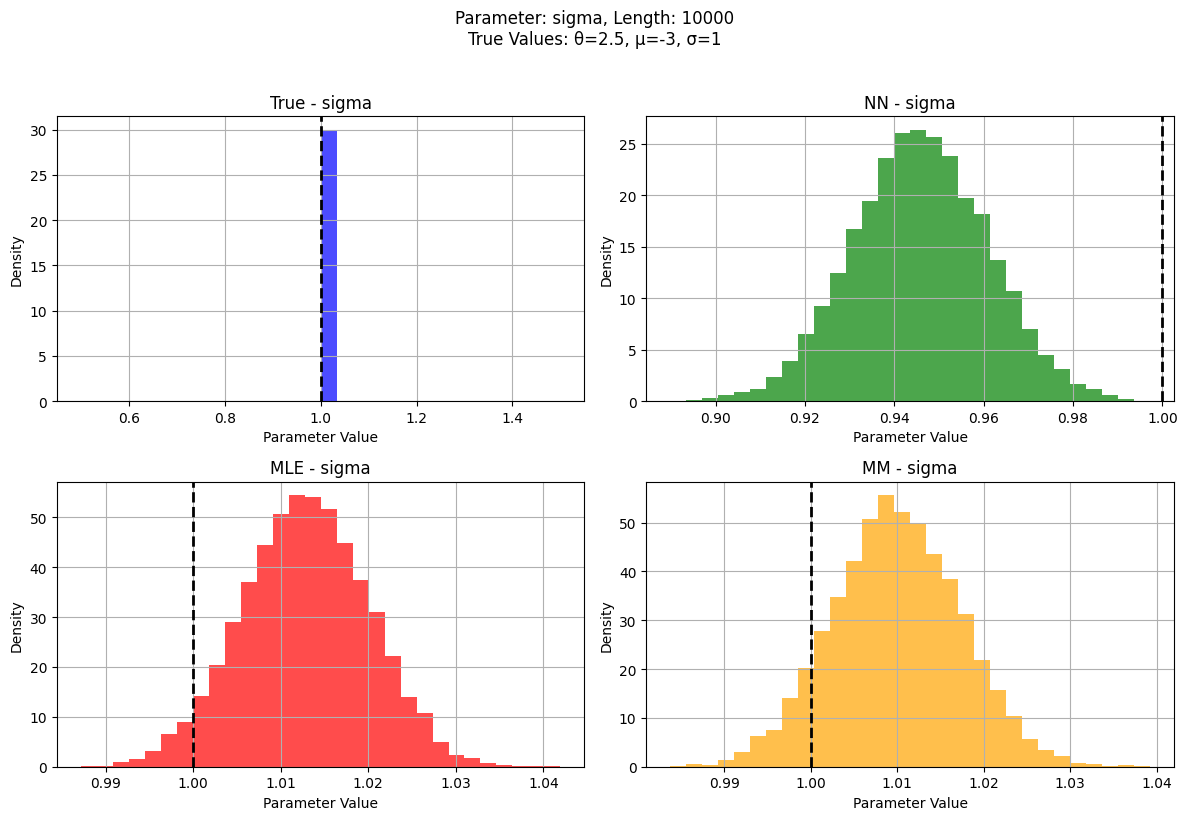

100%|██████████| 3/3 [3:58:11<00:00, 4763.92s/it]


In [13]:
plot_parameter_histograms(best_model)